In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
# sys.path.append("/home/jovyan/pschizhov/ODE_for_Neural_Optimal_Transport")
sys.path.append("..")


ADJOINT = False
SOLVER_METHOD = 'euler'
SOLVER_TS = 10
TOL = 1e-4

DEVICE_IDS = [0]

T_ITERS = 10
f_LR, T_LR = 1e-4, 1e-4
IMG_SIZE = 16

BATCH_SIZE = 64


# COST = 'mse' # Mean Squared Error
COST = 'dynamic_ot'

PLOT_INTERVAL = 100
CPKT_INTERVAL = 2000
MAX_STEPS = 100001
SEED = 0x000000


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
from torchdyn.core import NeuralODE
import functorch
import einops
import wandb

assert torch.cuda.is_available()
torch.cuda.set_device(f'cuda:{DEVICE_IDS[0]}')
torch.manual_seed(SEED); np.random.seed(SEED)
torch.cuda.is_available()

import os, sys
import time
from tqdm import tqdm
import gc

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from models.models import Unet
from models.ode import ODEBlock2
from src_not.resnet2 import ResNet_D
from src_not.tools import unfreeze, freeze
from models.simple_mlp import SimpleSequential, SimpleSequentialTimed

In [4]:
# INT_TIME = torch.cat((torch.linspace(0, 0.9, SOLVER_TS - 3), torch.tensor([0.95, 0.99, 1])), dim = 0)
INT_TIME = torch.linspace(0, 1, 10)
INT_TIME 

tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])

In [5]:
INT_TIME

tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])

In [6]:
ode_f = Unet(16).cuda()
T = ODEBlock2(ode_f,
              t_eval=INT_TIME.float(),
              sensitivity='adjoint' if ADJOINT else'autograd',
              method=SOLVER_METHOD).cuda()

f_y = ResNet_D(IMG_SIZE, nc=3, nfilter=64, nfilter_max=256).cuda()
f_x = ResNet_D(IMG_SIZE, nc=3, nfilter=64, nfilter_max=256).cuda()

0. 8 Гауссиан в moon dataset
1. 5 шагов эйлера, без adjointa -> потому что не честно решаем ОДУ -> чтобы показать, разрешение 32, fid раз в 1000 шагов (должен быть убывающим). Это скорее всего будет работать за адекватное время, но проблема с возвращением назад, для этого добавляем регуляризатор со случайной точкой на траекториии в [0, 1] -> есть шанс, возможно можно будет обратить.



In [7]:
import json
from src_not.tools import load_dataset, get_pushed_loader_stats
from src_not.fid_score import calculate_frechet_distance
from src_not.distributions import LoaderSampler

BATCH_SIZE = 64


def random_color(im):
    hue = 360*np.random.rand()
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6    
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

TRANSFORM = transforms.Compose([
    transforms.Resize(16),
    transforms.ToTensor(),
    random_color,
    transforms.Normalize([0.5],[0.5])
])

# Load train datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM)
idx = np.array(range(len(mnist_train)))
mnist_2 = torch.utils.data.Subset(mnist_train, idx[mnist_train.targets==2])
mnist_3 = torch.utils.data.Subset(mnist_train, idx[mnist_train.targets==3])
mnist_2_loader = torch.utils.data.DataLoader(mnist_2, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
mnist_3_loader = torch.utils.data.DataLoader(mnist_3, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Load test datasets
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM)
idx = np.array(range(len(mnist_test)))
mnist_2_test = torch.utils.data.Subset(mnist_test, idx[mnist_test.targets==2])
mnist_3_test = torch.utils.data.Subset(mnist_test, idx[mnist_test.targets==3])
mnist_2_test_loader = torch.utils.data.DataLoader(mnist_2_test, batch_size=BATCH_SIZE)
mnist_3_test_loader = torch.utils.data.DataLoader(mnist_3_test, batch_size=BATCH_SIZE)

# We pick a few samples from them for the qualitative analysis
X_test_fixed = next(iter(mnist_2_test_loader))[0]
Y_test_fixed = next(iter(mnist_3_test_loader))[0]
Z_test_fixed = torch.randn(BATCH_SIZE, 4, 1, 16, 16)
with torch.no_grad():
    XZ_test_fixed = torch.cat([X_test_fixed[:,None].repeat(1,4,1,1,1), Z_test_fixed], dim=2)
del Z_test_fixed

del mnist_2_test_loader, mnist_3_test_loader, mnist_test


batch_size = 64
device = 'cuda'
# train_sampler_x = LoaderSampler(DataLoader(mnist_2, shuffle=True, num_workers=8, batch_size=batch_size), device)
test_sampler_x = LoaderSampler(torch.utils.data.DataLoader(mnist_2_test, shuffle=True, num_workers=8, batch_size=batch_size), device)
# train_sampler_y = LoaderSampler(DataLoader(mnist_3, shuffle=True, num_workers=8, batch_size=batch_size), device)
test_sampler_y = LoaderSampler(torch.utils.data.DataLoader(mnist_3_test, shuffle=True, num_workers=8, batch_size=batch_size), device)

filename = 'MNIST3_16_test.json'
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data_y, sigma_data_y = data_stats['mu'], data_stats['sigma']
del data_stats
filename = 'MNIST2_16_test.json'
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data_x, sigma_data_x = data_stats['mu'], data_stats['sigma']
del data_stats


In [8]:
iter_mnist_2, iter_mnist_3 = iter(mnist_2_loader), iter(mnist_3_loader)

def sample_mnist_2():
    global iter_mnist_2, mnist_2_loader
    try:
        return next(iter_mnist_2)[0]
    except StopIteration:
        iter_mnist_2 = iter(mnist_2_loader)
        return next(iter_mnist_2)[0]

def sample_mnist_3():
    global iter_mnist_3, mnist_3_loader
    try:
        return next(iter_mnist_3)[0]
    except StopIteration:
        iter_mnist_3 = iter(mnist_3_loader)
        return next(iter_mnist_3)[0]

Random (unpaired) images from Colored MNIST-2 (1st row) and Colored MNIST-3 (2nd row) train sets


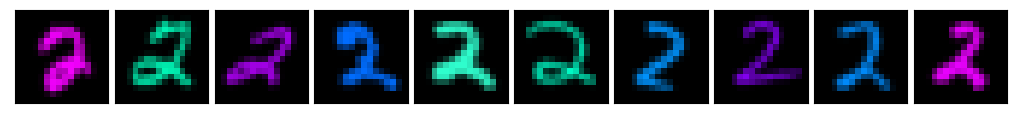

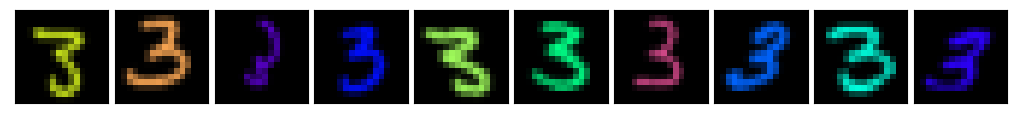

In [9]:
def plot_images(batch):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1), dpi=100)
    for i in range(10):
        axes[i].imshow(batch[i].mul(0.5).add(0.5).clip(0,1).permute(1,2,0))
        axes[i].set_xticks([]); axes[i].set_yticks([])
    fig.tight_layout(pad=0.1)

print('Random (unpaired) images from Colored MNIST-2 (1st row) and Colored MNIST-3 (2nd row) train sets')
plot_images(sample_mnist_2())
plot_images(sample_mnist_3())

In [10]:
def plot_trajectories(generator,
                      batch_size,
                      X_train_sampler,
                      Y_train_sampler,
                      # num_steps=25,
                      backward=False):
    
    global X_test_fixed, Y_test_fixed
    
    with torch.no_grad():          
        # int_time = generator.integration_time
        # new_int_time = torch.linspace(0, 1, num_steps)
        # if backward:
        #     new_int_time = torch.linspace(0, 1, num_steps).flip(dims=(0,))
        #     X_test_fixed, Y_test_fixed = Y_test_fixed, X_test_fixed
        # generator.integration_time = new_int_time 
        
        int_time = generator.integration_time
        new_int_time = int_time
        if backward:
            new_int_time = int_time.flip(dims=(0,))
            X_test_fixed, Y_test_fixed = Y_test_fixed, X_test_fixed
        generator.integration_time = new_int_time 
        num_steps = len(generator.integration_time)
        plot_time = min(num_steps, 10)
        step_time = max(plot_time // 10, 1)
        batch_size = min(batch_size, 10)
        
        # Test fixed
        fig1, axes1 = plt.subplots(plot_time + 1, batch_size, figsize=(plot_time + 1, batch_size), dpi=100)
        fig1.subplots_adjust(wspace=0, hspace=0)
        _, traj_test_fixed, _ = generator(torch.tensor(X_test_fixed[:batch_size], device='cuda'), return_trajectory=True)
        traj_test_fixed = traj_test_fixed.detach().cpu()
        for i in range(0, plot_time + 1, step_time):
            for j in range(batch_size):
                if i != plot_time:
                    axes1[i][j].imshow(traj_test_fixed[i, j].mul(0.5).add(0.5).clip(0,1).permute(1,2,0))
                    axes1[i][j].set_xticks([]); axes1[i][j].set_yticks([])
                    if j == 0:
                        axes1[i][j].set_ylabel(f't = {round(new_int_time[i].item(), 2)}')
                else:
                    axes1[i][j].imshow(Y_test_fixed[j].mul(0.5).add(0.5).clip(0,1).permute(1,2,0).detach().cpu())
                    axes1[i][j].set_xticks([]); axes1[i][j].set_yticks([])
                    if j == 0:
                        axes1[i][j].set_ylabel(f'{"P" if backward else "Q"} samples')
            fig1.tight_layout(pad=0.1, rect=[0, 0.03, 1, 0.95])
        if backward:
            fig1.suptitle('Backward fixed test')
        else:
            fig1.suptitle('Fixed test')
        
            
        if backward:
            X_train, Y_train = Y_train_sampler(), X_train_sampler()
        else:
            X_train, Y_train = X_train_sampler(), Y_train_sampler()
            
        fig4, axes4 = plt.subplots(plot_time + 1, batch_size, figsize=(plot_time + 1, batch_size), dpi=100)
        fig4.subplots_adjust(wspace=0, hspace=0)
        _, traj_train, _ = generator(torch.tensor(X_train, device='cuda'), return_trajectory=True)
        traj_train = traj_train.detach().cpu()
        for i in range(0, plot_time + 1, step_time):
            for j in range(batch_size):
                if i != plot_time:
                    axes4[i][j].imshow(traj_train[i, j].mul(0.5).add(0.5).clip(0,1).permute(1,2,0))
                    axes4[i][j].set_xticks([]); axes4[i][j].set_yticks([])
                    if j == 0:
                        axes4[i][j].set_ylabel(f't = {round(new_int_time[i].item(), 2)}')
                else:
                    axes4[i][j].imshow(Y_train[j].mul(0.5).add(0.5).clip(0,1).permute(1,2,0).detach().cpu())
                    axes4[i][j].set_xticks([]); axes4[i][j].set_yticks([])
                    if j == 0:
                        axes4[i][j].set_ylabel(f'{"P" if backward else "Q"} samples')
            fig4.tight_layout(pad=0.1, rect=[0, 0.03, 1, 0.95])
            # fig4.tight_layout(pad=0.001)
        if backward:
            fig4.suptitle('Backward train')
        else:
            fig4.suptitle('Train')
        
        generator.integration_time = int_time
        if backward:
            X_test_fixed, Y_test_fixed = Y_test_fixed, X_test_fixed
       

    return [fig1, fig4], [axes1, axes4]  
    

In [11]:

class Last_T(nn.Module):
    def __init__(self, T):
        super(Last_T, self).__init__()
        self.T = T
    def forward(self, x):
        res = self.T(x)
        return res[0]
    
    

# mu, sigma = get_pushed_loader_stats(Last_T(T), test_sampler_x.loader, batch_size=BATCH_SIZE, verbose=True)
# fid = calculate_frechet_distance(mu_data_y, sigma_data_y, mu, sigma)
# print(fid)


# int_time = T.integration_time
# new_int_time = int_time.flip(dims=(0,))
# T.integration_time = new_int_time
# mu, sigma = get_pushed_loader_stats(Last_T(T), test_sampler_y.loader, batch_size=BATCH_SIZE, verbose=True)
# fid = calculate_frechet_distance(mu_data_x, sigma_data_x, mu, sigma)
# T.integration_time = int_time
# print(fid)
  

In [12]:
# _ = plot_trajectories(T, BATCH_SIZE,
#                       sample_mnist_2,
#                       sample_mnist_3,
#                       # num_steps=10,
#                       backward=True)

In [13]:
from src_not.distributions import LoaderSampler
from src_not.tools import get_loader_stats
from src_not.tools import load_dataset, get_pushed_loader_stats
from src_not.fid_score import calculate_frechet_distance

In [14]:
def train_loop_v2(T, f_y, f_x, X_sampler, Y_sampler, BATCH_SIZE, T_ITERS=10, MAX_STEPS=100001, regularized=True):

    wandb.init(project='ode_strong_not', name=f'dynamic_ot_euler10step_MNIST_23_backforth') 
    OUTPUT_PATH = f'checkpoints/dynamic_ot_euler10step_MNIST_23_backforth'
    os.makedirs(OUTPUT_PATH, exist_ok=True)
    T_LR = 1e-4
    f_LR = 1e-4
    
    T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
    f_y_opt = torch.optim.Adam(f_y.parameters(), lr=f_LR, weight_decay=1e-10)
    f_x_opt = torch.optim.Adam(f_x.parameters(), lr=f_LR, weight_decay=1e-10)
    
    for step in tqdm(range(MAX_STEPS)):
        # T optimization
        unfreeze(T); freeze(f_y); freeze(f_x)
        avg_gen_opt_step_time = 0
        avg_num_func_eval_per_opt_step = 0
        
        if step % 2 == 0:
            for t_iter in range(T_ITERS):
                generator_opt_step_time = time.time()
                with torch.no_grad():
                    num_func_eval = T.nfe
                T_opt.zero_grad()
                X = X_sampler().cuda()
                t_eval, trajectories, reg_loss = T(X, return_trajectory=True)
                T_X = trajectories[-1]

                # total_loss
                if COST == 'mse':
                    T_loss = F.mse_loss(X, T_X).mean() - f_y(T_X).mean() + reg_loss      
                elif COST == 'dynamic_ot':
                    T_loss = reg_loss - f_y(T_X).mean() 
                else:
                    raise Exception('Unknown COST')
                T_loss.backward(); T_opt.step()
                
                with torch.no_grad():
                    num_func_eval_per_opt_step = T.nfe - num_func_eval
                generator_opt_step_time = time.time() - generator_opt_step_time
                avg_gen_opt_step_time += generator_opt_step_time
                avg_num_func_eval_per_opt_step += num_func_eval_per_opt_step

            avg_gen_opt_step_time /= T_ITERS 
            avg_num_func_eval_per_opt_step /= T_ITERS
            # del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()

            # f_y optimization
            freeze(T); unfreeze(f_y)
            discriminator_opt_step_time = time.time()
            X = X_sampler().cuda()
            with torch.no_grad():
                T_X, _ = T(X)
            Y = Y_sampler().cuda()
            f_y_opt.zero_grad()
            f_loss = f_y(T_X).mean() - f_y(Y).mean()
            f_loss.backward(); f_y_opt.step();
            discriminator_opt_step_time = time.time() - discriminator_opt_step_time
            wandb.log({'f_loss' : f_loss.item(),
                       'T_loss' : T_loss.item(),
                       'reg_loss' : reg_loss.item(),
                      'avg_num_func_eval_per_opt_step' : avg_num_func_eval_per_opt_step,
                      'avg_gen_opt_step_time' : avg_gen_opt_step_time,
                      'discriminator_opt_step_time' : discriminator_opt_step_time
                      }, step=step) 
        else:
            # set the reverse mode to generator
            int_time = T.integration_time
            new_int_time = int_time.flip(dims=(0,))
            T.integration_time = new_int_time
            
            for t_iter in range(T_ITERS):
                generator_opt_step_time = time.time()
                with torch.no_grad():
                    num_func_eval = T.nfe
                T_opt.zero_grad()
                Y = Y_sampler().cuda()
                # X = X_sampler().cuda()
                t_eval, trajectories, reg_loss = T(Y, return_trajectory=True)
                # t_eval, trajectories, reg_loss = T(X, return_trajectory=True)
                T_Y = trajectories[-1]
                # T_X = trajectories[-1]

                # total_loss
                if COST == 'mse':
                    T_loss = F.mse_loss(Y, T_Y).mean() - f_x(T_Y).mean() + reg_loss      
                elif COST == 'dynamic_ot':
                    T_loss = reg_loss - f_x(T_Y).mean() 
                else:
                    raise Exception('Unknown COST')
                T_loss.backward(); T_opt.step()
                with torch.no_grad():
                    num_func_eval_per_opt_step = T.nfe - num_func_eval

                generator_opt_step_time = time.time() - generator_opt_step_time
                avg_gen_opt_step_time += generator_opt_step_time
                avg_num_func_eval_per_opt_step += num_func_eval_per_opt_step

            avg_gen_opt_step_time /= T_ITERS 
            avg_num_func_eval_per_opt_step /= T_ITERS
            # del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()

            # f_x optimization
            freeze(T); unfreeze(f_x)
            discriminator_opt_step_time = time.time()
            Y = Y_sampler().cuda()
            with torch.no_grad():
                T_Y, _ = T(Y)
            X = X_sampler().cuda()
            f_x_opt.zero_grad()
            f_loss = f_x(T_Y).mean() - f_x(X).mean()
            f_loss.backward(); f_x_opt.step();
            discriminator_opt_step_time = time.time() - discriminator_opt_step_time
            wandb.log({'f_loss' : f_loss.item(),
                       'T_loss' : T_loss.item(),
                       'reg_loss' : reg_loss.item(),
                      'avg_num_func_eval_per_opt_step' : avg_num_func_eval_per_opt_step,
                      'avg_gen_opt_step_time' : avg_gen_opt_step_time,
                      'discriminator_opt_step_time' : discriminator_opt_step_time
                      }, step=step)
            # return forward time stamps
            T.integration_time = int_time


        if step % PLOT_INTERVAL == 0:
            print('Plotting')
            # clear_output(wait=True)
            figs, axes = plot_trajectories(T, BATCH_SIZE,
                                              sample_mnist_2,
                                              sample_mnist_3,
                                              # num_steps=10,
                                              backward=False)
            figs_total = figs
            figs, axes = plot_trajectories(T, BATCH_SIZE,
                              sample_mnist_2,
                              sample_mnist_3,
                              # num_steps=10,
                              backward=True)
            figs_total += figs

            wandb.log({'Fixed Images' : [wandb.Image(fig) for fig in figs_total]}, step=step) 
            [plt.show(fig) for fig in figs_total]; [plt.close(fig) for fig in figs_total]

        if step % CPKT_INTERVAL == 0:
            
            mu, sigma = get_pushed_loader_stats(Last_T(T), test_sampler_x.loader, batch_size=BATCH_SIZE, verbose=True)
            fid_forward = calculate_frechet_distance(mu_data_y, sigma_data_y, mu, sigma)
            print(fid_forward)

            int_time = T.integration_time
            new_int_time = int_time.flip(dims=(0,))
            T.integration_time = new_int_time
            mu, sigma = get_pushed_loader_stats(Last_T(T), test_sampler_y.loader, batch_size=BATCH_SIZE, verbose=True)
            fid_backward = calculate_frechet_distance(mu_data_x, sigma_data_x, mu, sigma)
            T.integration_time = int_time
            print(fid_backward)
            wandb.log({'FID_forward' : fid_forward,
                      'FID_backward' : fid_backward,
                  }, step=step) 

            torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'{SEED}_{step}.pt'))
            torch.save(f_x.state_dict(), os.path.join(OUTPUT_PATH, f'f_x_{SEED}_{step}.pt'))
            torch.save(f_y.state_dict(), os.path.join(OUTPUT_PATH, f'f_y_{SEED}_{step}.pt'))
            torch.save(f_x_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_x_opt_{SEED}_{step}.pt'))
            torch.save(f_y_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_y_opt_{SEED}_{step}.pt'))
            torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{step}.pt'))

In [15]:
def train_loop_v3(T, f_y, f_x, X_sampler, Y_sampler, BATCH_SIZE, T_ITERS=10, MAX_STEPS=100001, regularized=True):

    wandb.init(project='ode_strong_not', name=f'dynamic_ot_euler10step_MNIST_23_backforth_v3') 
    OUTPUT_PATH = f'checkpoints/dynamic_ot_euler10step_MNIST_23_backforth_v3'
    os.makedirs(OUTPUT_PATH, exist_ok=True)
    T_LR = 1e-4
    f_LR = 1e-4
    
    T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
    f_y_opt = torch.optim.Adam(f_y.parameters(), lr=f_LR, weight_decay=1e-10)
    f_x_opt = torch.optim.Adam(f_x.parameters(), lr=f_LR, weight_decay=1e-10)
    
    for step in tqdm(range(MAX_STEPS)):
        # T optimization
        unfreeze(T); freeze(f_y); freeze(f_x)
        avg_gen_opt_step_time = 0
        avg_num_func_eval_per_opt_step = 0
        
        if step % 2 == 0:
            for t_iter in range(T_ITERS):
                generator_opt_step_time = time.time()
                with torch.no_grad():
                    num_func_eval = T.nfe
                T_opt.zero_grad()
                X = X_sampler().cuda()
                t_eval, trajectories, reg_loss = T(X, return_trajectory=True)
                T_X = trajectories[-1]

                # total_loss
                if COST == 'mse':
                    T_loss = F.mse_loss(X, T_X).mean() - f_y(T_X).mean() + reg_loss      
                elif COST == 'dynamic_ot':
                    T_loss = reg_loss - f_y(T_X).mean() 
                else:
                    raise Exception('Unknown COST')
                T_loss.backward(); T_opt.step()
                
                with torch.no_grad():
                    num_func_eval_per_opt_step = T.nfe - num_func_eval
                generator_opt_step_time = time.time() - generator_opt_step_time
                avg_gen_opt_step_time += generator_opt_step_time
                avg_num_func_eval_per_opt_step += num_func_eval_per_opt_step

            avg_gen_opt_step_time /= T_ITERS 
            avg_num_func_eval_per_opt_step /= T_ITERS
            # del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()


        else:
            # set the reverse mode to generator
            int_time = T.integration_time
            new_int_time = int_time.flip(dims=(0,))
            T.integration_time = new_int_time
            
            for t_iter in range(T_ITERS):
                generator_opt_step_time = time.time()
                with torch.no_grad():
                    num_func_eval = T.nfe
                T_opt.zero_grad()
                Y = Y_sampler().cuda()
                # X = X_sampler().cuda()
                t_eval, trajectories, reg_loss = T(Y, return_trajectory=True)
                # t_eval, trajectories, reg_loss = T(X, return_trajectory=True)
                T_Y = trajectories[-1]
                # T_X = trajectories[-1]

                # total_loss
                if COST == 'mse':
                    T_loss = F.mse_loss(Y, T_Y).mean() - f_x(T_Y).mean() + reg_loss      
                elif COST == 'dynamic_ot':
                    T_loss = reg_loss - f_x(T_Y).mean() 
                else:
                    raise Exception('Unknown COST')
                T_loss.backward(); T_opt.step()
                with torch.no_grad():
                    num_func_eval_per_opt_step = T.nfe - num_func_eval

                generator_opt_step_time = time.time() - generator_opt_step_time
                avg_gen_opt_step_time += generator_opt_step_time
                avg_num_func_eval_per_opt_step += num_func_eval_per_opt_step

            avg_gen_opt_step_time /= T_ITERS 
            avg_num_func_eval_per_opt_step /= T_ITERS
            T.integration_time = int_time
            # del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()
            
            
        discriminator_opt_step_time = time.time()
        freeze(T); unfreeze(f_y); unfreeze(f_x)
        
        X = X_sampler().cuda()
        Y = Y_sampler().cuda()
        with torch.no_grad():
            T_X, _ = T(X)
            int_time = T.integration_time
            new_int_time = int_time.flip(dims=(0,))
            T.integration_time = new_int_time
            T_Y, _ = T(Y)
            T.integration_time = int_time
        
        
        # f_y optimization
        f_y_opt.zero_grad()
        f_y_loss = f_y(T_X).mean() - f_y(Y).mean()
        f_y_loss.backward(); f_y_opt.step(); 
        # f_x optimization
        f_x_opt.zero_grad()
        f_x_loss = f_x(T_Y).mean() - f_x(X).mean()
        f_x_loss.backward(); f_x_opt.step();
        discriminator_opt_step_time = time.time() - discriminator_opt_step_time
        wandb.log({'f_y_loss' : f_y_loss.item(),
                   'f_x_loss' : f_x_loss.item(),
                   'T_loss' : T_loss.item(),
                   'reg_loss' : reg_loss.item(),
                  'avg_num_func_eval_per_opt_step' : avg_num_func_eval_per_opt_step,
                  'avg_gen_opt_step_time' : avg_gen_opt_step_time,
                  'discriminator_opt_step_time' : discriminator_opt_step_time
                  }, step=step)

        if step % PLOT_INTERVAL == 0:
            print('Plotting')
            # clear_output(wait=True)
            figs, axes = plot_trajectories(T, BATCH_SIZE,
                                              sample_mnist_2,
                                              sample_mnist_3,
                                              # num_steps=10,
                                              backward=False)
            figs_total = figs
            figs, axes = plot_trajectories(T, BATCH_SIZE,
                              sample_mnist_2,
                              sample_mnist_3,
                              # num_steps=10,
                              backward=True)
            figs_total += figs

            wandb.log({'Fixed Images' : [wandb.Image(fig) for fig in figs_total]}, step=step) 
            [plt.show(fig) for fig in figs_total]; [plt.close(fig) for fig in figs_total]

        if step % CPKT_INTERVAL == 0:
            
            mu, sigma = get_pushed_loader_stats(Last_T(T), test_sampler_x.loader, batch_size=BATCH_SIZE, verbose=True)
            fid_forward = calculate_frechet_distance(mu_data_y, sigma_data_y, mu, sigma)
            print(fid_forward)

            int_time = T.integration_time
            new_int_time = int_time.flip(dims=(0,))
            T.integration_time = new_int_time
            mu, sigma = get_pushed_loader_stats(Last_T(T), test_sampler_y.loader, batch_size=BATCH_SIZE, verbose=True)
            fid_backward = calculate_frechet_distance(mu_data_x, sigma_data_x, mu, sigma)
            T.integration_time = int_time
            print(fid_backward)
            wandb.log({'FID_forward' : fid_forward,
                      'FID_backward' : fid_backward,
                  }, step=step) 

            torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'{SEED}_{step}.pt'))
            torch.save(f_x.state_dict(), os.path.join(OUTPUT_PATH, f'f_x_{SEED}_{step}.pt'))
            torch.save(f_y.state_dict(), os.path.join(OUTPUT_PATH, f'f_y_{SEED}_{step}.pt'))
            torch.save(f_x_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_x_opt_{SEED}_{step}.pt'))
            torch.save(f_y_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_y_opt_{SEED}_{step}.pt'))
            torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{step}.pt'))

In [16]:
def train_loop_v3(T, f_y, f_x, X_sampler, Y_sampler, BATCH_SIZE, T_ITERS=10, MAX_STEPS=100001, regularized=True):

    wandb.init(project='ode_strong_not', name=f'dynamic_ot_euler10step_MNIST_23_backforth_v4') 
    OUTPUT_PATH = f'checkpoints/dynamic_ot_euler10step_MNIST_23_backforth_v4'
    os.makedirs(OUTPUT_PATH, exist_ok=True)
    T_LR = 1e-4
    f_LR = 1e-4
    
    T_opt1 = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
    T_opt2 = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
    f_y_opt = torch.optim.Adam(f_y.parameters(), lr=f_LR, weight_decay=1e-10)
    f_x_opt = torch.optim.Adam(f_x.parameters(), lr=f_LR, weight_decay=1e-10)
    
    for step in tqdm(range(MAX_STEPS)):
        # T optimization
        unfreeze(T); freeze(f_y); freeze(f_x)
        avg_gen_opt_step_time = 0
        avg_num_func_eval_per_opt_step = 0
        
        if step % 2 == 0:
            for t_iter in range(T_ITERS):
                generator_opt_step_time = time.time()
                with torch.no_grad():
                    num_func_eval = T.nfe
                T_opt.zero_grad()
                X = X_sampler().cuda()
                t_eval, trajectories, reg_loss = T(X, return_trajectory=True)
                T_X = trajectories[-1]

                # total_loss
                if COST == 'mse':
                    T_loss = F.mse_loss(X, T_X).mean() - f_y(T_X).mean() + reg_loss      
                elif COST == 'dynamic_ot':
                    T_loss = reg_loss - f_y(T_X).mean() 
                else:
                    raise Exception('Unknown COST')
                T_loss.backward(); T_opt1.step()
                
                with torch.no_grad():
                    num_func_eval_per_opt_step = T.nfe - num_func_eval
                generator_opt_step_time = time.time() - generator_opt_step_time
                avg_gen_opt_step_time += generator_opt_step_time
                avg_num_func_eval_per_opt_step += num_func_eval_per_opt_step

            avg_gen_opt_step_time /= T_ITERS 
            avg_num_func_eval_per_opt_step /= T_ITERS
            # del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()


        else:
            # set the reverse mode to generator
            int_time = T.integration_time
            new_int_time = int_time.flip(dims=(0,))
            T.integration_time = new_int_time
            
            for t_iter in range(T_ITERS):
                generator_opt_step_time = time.time()
                with torch.no_grad():
                    num_func_eval = T.nfe
                T_opt.zero_grad()
                Y = Y_sampler().cuda()
                # X = X_sampler().cuda()
                t_eval, trajectories, reg_loss = T(Y, return_trajectory=True)
                # t_eval, trajectories, reg_loss = T(X, return_trajectory=True)
                T_Y = trajectories[-1]
                # T_X = trajectories[-1]

                # total_loss
                if COST == 'mse':
                    T_loss = F.mse_loss(Y, T_Y).mean() - f_x(T_Y).mean() + reg_loss      
                elif COST == 'dynamic_ot':
                    T_loss = reg_loss - f_x(T_Y).mean() 
                else:
                    raise Exception('Unknown COST')
                T_loss.backward(); T_opt2.step()
                with torch.no_grad():
                    num_func_eval_per_opt_step = T.nfe - num_func_eval

                generator_opt_step_time = time.time() - generator_opt_step_time
                avg_gen_opt_step_time += generator_opt_step_time
                avg_num_func_eval_per_opt_step += num_func_eval_per_opt_step

            avg_gen_opt_step_time /= T_ITERS 
            avg_num_func_eval_per_opt_step /= T_ITERS
            T.integration_time = int_time
            # del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()
            
            
        discriminator_opt_step_time = time.time()
        freeze(T); unfreeze(f_y); unfreeze(f_x)
        
        X = X_sampler().cuda()
        Y = Y_sampler().cuda()
        with torch.no_grad():
            T_X, _ = T(X)
            int_time = T.integration_time
            new_int_time = int_time.flip(dims=(0,))
            T.integration_time = new_int_time
            T_Y, _ = T(Y)
            T.integration_time = int_time
        
        
        # f_y optimization
        f_y_opt.zero_grad()
        f_y_loss = f_y(T_X).mean() - f_y(Y).mean()
        f_y_loss.backward(); f_y_opt.step(); 
        # f_x optimization
        f_x_opt.zero_grad()
        f_x_loss = f_x(T_Y).mean() - f_x(X).mean()
        f_x_loss.backward(); f_x_opt.step();
        discriminator_opt_step_time = time.time() - discriminator_opt_step_time
        wandb.log({'f_y_loss' : f_y_loss.item(),
                   'f_x_loss' : f_x_loss.item(),
                   'T_loss' : T_loss.item(),
                   'reg_loss' : reg_loss.item(),
                  'avg_num_func_eval_per_opt_step' : avg_num_func_eval_per_opt_step,
                  'avg_gen_opt_step_time' : avg_gen_opt_step_time,
                  'discriminator_opt_step_time' : discriminator_opt_step_time
                  }, step=step)

        if step % PLOT_INTERVAL == 0:
            print('Plotting')
            # clear_output(wait=True)
            figs, axes = plot_trajectories(T, BATCH_SIZE,
                                              sample_mnist_2,
                                              sample_mnist_3,
                                              # num_steps=10,
                                              backward=False)
            figs_total = figs
            figs, axes = plot_trajectories(T, BATCH_SIZE,
                              sample_mnist_2,
                              sample_mnist_3,
                              # num_steps=10,
                              backward=True)
            figs_total += figs

            wandb.log({'Fixed Images' : [wandb.Image(fig) for fig in figs_total]}, step=step) 
            [plt.show(fig) for fig in figs_total]; [plt.close(fig) for fig in figs_total]

        if step % CPKT_INTERVAL == 0:
            
            mu, sigma = get_pushed_loader_stats(Last_T(T), test_sampler_x.loader, batch_size=BATCH_SIZE, verbose=True)
            fid_forward = calculate_frechet_distance(mu_data_y, sigma_data_y, mu, sigma)
            print(fid_forward)

            int_time = T.integration_time
            new_int_time = int_time.flip(dims=(0,))
            T.integration_time = new_int_time
            mu, sigma = get_pushed_loader_stats(Last_T(T), test_sampler_y.loader, batch_size=BATCH_SIZE, verbose=True)
            fid_backward = calculate_frechet_distance(mu_data_x, sigma_data_x, mu, sigma)
            T.integration_time = int_time
            print(fid_backward)
            wandb.log({'FID_forward' : fid_forward,
                      'FID_backward' : fid_backward,
                  }, step=step) 

            torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'{SEED}_{step}.pt'))
            torch.save(f_x.state_dict(), os.path.join(OUTPUT_PATH, f'f_x_{SEED}_{step}.pt'))
            torch.save(f_y.state_dict(), os.path.join(OUTPUT_PATH, f'f_y_{SEED}_{step}.pt'))
            torch.save(f_x_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_x_opt_{SEED}_{step}.pt'))
            torch.save(f_y_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_y_opt_{SEED}_{step}.pt'))
            torch.save(T_opt1.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt1_{SEED}_{step}.pt'))
            torch.save(T_opt2.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt2_{SEED}_{step}.pt'))

In [17]:
def train_loop_v4(T, f_y, f_x, X_sampler, Y_sampler, BATCH_SIZE, T_ITERS=10, MAX_STEPS=100001, regularized=True):

    wandb.init(project='ode_strong_not', name=f'dynamic_ot_euler10step_MNIST_23_backforth_v4') 
    OUTPUT_PATH = f'checkpoints/dynamic_ot_euler10step_MNIST_23_backforth_v4'
    os.makedirs(OUTPUT_PATH, exist_ok=True)
    T_LR = 1e-4
    f_LR = 1e-4
    
    T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
    f_y_opt = torch.optim.Adam(f_y.parameters(), lr=f_LR, weight_decay=1e-10)
    f_x_opt = torch.optim.Adam(f_x.parameters(), lr=f_LR, weight_decay=1e-10)
    flag = False
    for step in tqdm(range(MAX_STEPS)):
        # T optimization
        unfreeze(T); freeze(f_y); freeze(f_x)
        avg_gen_opt_step_time = 0
        avg_num_func_eval_per_opt_step = 0
        
        if step%10 == 0:
            flag = not flag
        
        if flag:
            for t_iter in range(T_ITERS):
                generator_opt_step_time = time.time()
                with torch.no_grad():
                    num_func_eval = T.nfe
                T_opt.zero_grad()
                X = X_sampler().cuda()
                t_eval, trajectories, reg_loss = T(X, return_trajectory=True)
                T_X = trajectories[-1]

                # total_loss
                if COST == 'mse':
                    T_loss = F.mse_loss(X, T_X).mean() - f_y(T_X).mean() + reg_loss      
                elif COST == 'dynamic_ot':
                    T_loss = reg_loss - f_y(T_X).mean() 
                else:
                    raise Exception('Unknown COST')
                T_loss.backward(); T_opt.step()
                
                with torch.no_grad():
                    num_func_eval_per_opt_step = T.nfe - num_func_eval
                generator_opt_step_time = time.time() - generator_opt_step_time
                avg_gen_opt_step_time += generator_opt_step_time
                avg_num_func_eval_per_opt_step += num_func_eval_per_opt_step

            avg_gen_opt_step_time /= T_ITERS 
            avg_num_func_eval_per_opt_step /= T_ITERS
            # del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()

            # f_y optimization
            freeze(T); unfreeze(f_y)
            discriminator_opt_step_time = time.time()
            X = X_sampler().cuda()
            with torch.no_grad():
                T_X, _ = T(X)
            Y = Y_sampler().cuda()
            f_y_opt.zero_grad()
            f_loss = f_y(T_X).mean() - f_y(Y).mean()
            f_loss.backward(); f_y_opt.step();
            discriminator_opt_step_time = time.time() - discriminator_opt_step_time
            wandb.log({'f_loss' : f_loss.item(),
                       'T_loss' : T_loss.item(),
                       'reg_loss' : reg_loss.item(),
                      'avg_num_func_eval_per_opt_step' : avg_num_func_eval_per_opt_step,
                      'avg_gen_opt_step_time' : avg_gen_opt_step_time,
                      'discriminator_opt_step_time' : discriminator_opt_step_time
                      }, step=step) 
        else:
            # set the reverse mode to generator
            int_time = T.integration_time
            new_int_time = int_time.flip(dims=(0,))
            T.integration_time = new_int_time
            
            for t_iter in range(T_ITERS):
                generator_opt_step_time = time.time()
                with torch.no_grad():
                    num_func_eval = T.nfe
                T_opt.zero_grad()
                Y = Y_sampler().cuda()
                # X = X_sampler().cuda()
                t_eval, trajectories, reg_loss = T(Y, return_trajectory=True)
                # t_eval, trajectories, reg_loss = T(X, return_trajectory=True)
                T_Y = trajectories[-1]
                # T_X = trajectories[-1]

                # total_loss
                if COST == 'mse':
                    T_loss = F.mse_loss(Y, T_Y).mean() - f_x(T_Y).mean() + reg_loss      
                elif COST == 'dynamic_ot':
                    T_loss = reg_loss - f_x(T_Y).mean() 
                else:
                    raise Exception('Unknown COST')
                T_loss.backward(); T_opt.step()
                with torch.no_grad():
                    num_func_eval_per_opt_step = T.nfe - num_func_eval

                generator_opt_step_time = time.time() - generator_opt_step_time
                avg_gen_opt_step_time += generator_opt_step_time
                avg_num_func_eval_per_opt_step += num_func_eval_per_opt_step

            avg_gen_opt_step_time /= T_ITERS 
            avg_num_func_eval_per_opt_step /= T_ITERS
            # del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()

            # f_x optimization
            freeze(T); unfreeze(f_x)
            discriminator_opt_step_time = time.time()
            Y = Y_sampler().cuda()
            with torch.no_grad():
                T_Y, _ = T(Y)
            X = X_sampler().cuda()
            f_x_opt.zero_grad()
            f_loss = f_x(T_Y).mean() - f_x(X).mean()
            f_loss.backward(); f_x_opt.step();
            discriminator_opt_step_time = time.time() - discriminator_opt_step_time
            wandb.log({'f_loss' : f_loss.item(),
                       'T_loss' : T_loss.item(),
                       'reg_loss' : reg_loss.item(),
                      'avg_num_func_eval_per_opt_step' : avg_num_func_eval_per_opt_step,
                      'avg_gen_opt_step_time' : avg_gen_opt_step_time,
                      'discriminator_opt_step_time' : discriminator_opt_step_time
                      }, step=step)
            # return forward time stamps
            T.integration_time = int_time


        if step % PLOT_INTERVAL == 0:
            print('Plotting')
            # clear_output(wait=True)
            figs, axes = plot_trajectories(T, BATCH_SIZE,
                                              sample_mnist_2,
                                              sample_mnist_3,
                                              # num_steps=10,
                                              backward=False)
            figs_total = figs
            figs, axes = plot_trajectories(T, BATCH_SIZE,
                              sample_mnist_2,
                              sample_mnist_3,
                              # num_steps=10,
                              backward=True)
            figs_total += figs

            wandb.log({'Fixed Images' : [wandb.Image(fig) for fig in figs_total]}, step=step) 
            [plt.show(fig) for fig in figs_total]; [plt.close(fig) for fig in figs_total]

        if step % CPKT_INTERVAL == 0:
            
            mu, sigma = get_pushed_loader_stats(Last_T(T), test_sampler_x.loader, batch_size=BATCH_SIZE, verbose=True)
            fid_forward = calculate_frechet_distance(mu_data_y, sigma_data_y, mu, sigma)
            print(fid_forward)

            int_time = T.integration_time
            new_int_time = int_time.flip(dims=(0,))
            T.integration_time = new_int_time
            mu, sigma = get_pushed_loader_stats(Last_T(T), test_sampler_y.loader, batch_size=BATCH_SIZE, verbose=True)
            fid_backward = calculate_frechet_distance(mu_data_x, sigma_data_x, mu, sigma)
            T.integration_time = int_time
            print(fid_backward)
            wandb.log({'FID_forward' : fid_forward,
                      'FID_backward' : fid_backward,
                  }, step=step) 

            torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'{SEED}_{step}.pt'))
            torch.save(f_x.state_dict(), os.path.join(OUTPUT_PATH, f'f_x_{SEED}_{step}.pt'))
            torch.save(f_y.state_dict(), os.path.join(OUTPUT_PATH, f'f_y_{SEED}_{step}.pt'))
            torch.save(f_x_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_x_opt_{SEED}_{step}.pt'))
            torch.save(f_y_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_y_opt_{SEED}_{step}.pt'))
            torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{step}.pt'))

In [18]:
def train_loop_v5(T, f_y, f_x, X_sampler, Y_sampler, BATCH_SIZE, T_ITERS=10, MAX_STEPS=100001, regularized=True):

    wandb.init(project='ode_strong_not', name=f'dynamic_ot_euler10step_MNIST_23_backforth_elfat') 
    OUTPUT_PATH = f'checkpoints/dynamic_ot_euler10step_MNIST_23_backforth_elfat'
    os.makedirs(OUTPUT_PATH, exist_ok=True)
    T_LR = 1e-4
    f_LR = 1e-4
    
    T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
    f_y_opt = torch.optim.Adam(f_y.parameters(), lr=f_LR, weight_decay=1e-10)
    f_x_opt = torch.optim.Adam(f_x.parameters(), lr=f_LR, weight_decay=1e-10)
    flag = False
    for step in tqdm(range(MAX_STEPS)):
        # T optimization
        unfreeze(T); freeze(f_y); freeze(f_x)
        avg_gen_opt_step_time = 0
        avg_num_func_eval_per_opt_step = 0
        
        # if step%10 == 0:
        #     flag = not flag
        
        if (step + 1) % 10 != 0:
            for t_iter in range(T_ITERS):
                generator_opt_step_time = time.time()
                with torch.no_grad():
                    num_func_eval = T.nfe
                T_opt.zero_grad()
                X = X_sampler().cuda()
                print('forward int_time = ', T.integration_time)
                t_eval, trajectories, reg_loss = T(X, return_trajectory=True)
                T_X = trajectories[-1]

                # total_loss
                if COST == 'mse':
                    T_loss = F.mse_loss(X, T_X).mean() - f_y(T_X).mean() + reg_loss      
                elif COST == 'dynamic_ot':
                    T_loss = reg_loss - f_y(T_X).mean() 
                else:
                    raise Exception('Unknown COST')
                T_loss.backward(); T_opt.step()
                
                with torch.no_grad():
                    num_func_eval_per_opt_step = T.nfe - num_func_eval
                generator_opt_step_time = time.time() - generator_opt_step_time
                avg_gen_opt_step_time += generator_opt_step_time
                avg_num_func_eval_per_opt_step += num_func_eval_per_opt_step

            avg_gen_opt_step_time /= T_ITERS 
            avg_num_func_eval_per_opt_step /= T_ITERS
            # del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()

            # f_y optimization
            freeze(T); unfreeze(f_y)
            discriminator_opt_step_time = time.time()
            X = X_sampler().cuda()
            
            with torch.no_grad():
                print('forward int_time = ', T.integration_time)
                T_X, _ = T(X)
            Y = Y_sampler().cuda()
            f_y_opt.zero_grad()
            f_loss = f_y(T_X).mean() - f_y(Y).mean()
            f_loss.backward(); f_y_opt.step();
            discriminator_opt_step_time = time.time() - discriminator_opt_step_time
            wandb.log({'f_loss' : f_loss.item(),
                       'T_loss' : T_loss.item(),
                       'reg_loss' : reg_loss.item(),
                      'avg_num_func_eval_per_opt_step' : avg_num_func_eval_per_opt_step,
                      'avg_gen_opt_step_time' : avg_gen_opt_step_time,
                      'discriminator_opt_step_time' : discriminator_opt_step_time
                      }, step=step) 
        else:
            # set the reverse mode to generator
            int_time = T.integration_time
            new_int_time = int_time.flip(dims=(0,))
            T.integration_time = new_int_time
            
            for t_iter in range(T_ITERS):
                generator_opt_step_time = time.time()
                with torch.no_grad():
                    num_func_eval = T.nfe
                T_opt.zero_grad()
                Y = Y_sampler().cuda()
                # X = X_sampler().cuda()
                print('backward int_time = ', T.integration_time)
                t_eval, trajectories, reg_loss = T(Y, return_trajectory=True)
                # t_eval, trajectories, reg_loss = T(X, return_trajectory=True)
                T_Y = trajectories[-1]
                # T_X = trajectories[-1]

                # total_loss
                if COST == 'mse':
                    T_loss = F.mse_loss(Y, T_Y).mean() - f_x(T_Y).mean() + reg_loss      
                elif COST == 'dynamic_ot':
                    T_loss = reg_loss - f_x(T_Y).mean() 
                else:
                    raise Exception('Unknown COST')
                T_loss.backward(); T_opt.step()
                with torch.no_grad():
                    num_func_eval_per_opt_step = T.nfe - num_func_eval

                generator_opt_step_time = time.time() - generator_opt_step_time
                avg_gen_opt_step_time += generator_opt_step_time
                avg_num_func_eval_per_opt_step += num_func_eval_per_opt_step

            avg_gen_opt_step_time /= T_ITERS 
            avg_num_func_eval_per_opt_step /= T_ITERS
            # del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()

            # f_x optimization
            freeze(T); unfreeze(f_x)
            discriminator_opt_step_time = time.time()
            Y = Y_sampler().cuda()
            with torch.no_grad():
                print('backward int_time = ', T.integration_time)      
                T_Y, _ = T(Y)
            X = X_sampler().cuda()
            f_x_opt.zero_grad()
            f_loss = f_x(T_Y).mean() - f_x(X).mean()
            f_loss.backward(); f_x_opt.step();
            discriminator_opt_step_time = time.time() - discriminator_opt_step_time
            wandb.log({'f_loss' : f_loss.item(),
                       'T_loss' : T_loss.item(),
                       'reg_loss' : reg_loss.item(),
                      'avg_num_func_eval_per_opt_step' : avg_num_func_eval_per_opt_step,
                      'avg_gen_opt_step_time' : avg_gen_opt_step_time,
                      'discriminator_opt_step_time' : discriminator_opt_step_time
                      }, step=step)
            # return forward time stamps
            T.integration_time = int_time


        if step % PLOT_INTERVAL == 0:
            print('Plotting')
            # clear_output(wait=True)
            figs, axes = plot_trajectories(T, BATCH_SIZE,
                                              sample_mnist_2,
                                              sample_mnist_3,
                                              # num_steps=10,
                                              backward=False)
            figs_total = figs
            figs, axes = plot_trajectories(T, BATCH_SIZE,
                              sample_mnist_2,
                              sample_mnist_3,
                              # num_steps=10,
                              backward=True)
            figs_total += figs

            wandb.log({'Fixed Images' : [wandb.Image(fig) for fig in figs_total]}, step=step) 
            [plt.show(fig) for fig in figs_total]; [plt.close(fig) for fig in figs_total]

        if step % CPKT_INTERVAL == 0:
            
            mu, sigma = get_pushed_loader_stats(Last_T(T), test_sampler_x.loader, batch_size=BATCH_SIZE, verbose=True)
            fid_forward = calculate_frechet_distance(mu_data_y, sigma_data_y, mu, sigma)
            print(fid_forward)

            int_time = T.integration_time
            new_int_time = int_time.flip(dims=(0,))
            T.integration_time = new_int_time
            mu, sigma = get_pushed_loader_stats(Last_T(T), test_sampler_y.loader, batch_size=BATCH_SIZE, verbose=True)
            fid_backward = calculate_frechet_distance(mu_data_x, sigma_data_x, mu, sigma)
            T.integration_time = int_time
            print(fid_backward)
            wandb.log({'FID_forward' : fid_forward,
                      'FID_backward' : fid_backward,
                  }, step=step) 

            torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'{SEED}_{step}.pt'))
            torch.save(f_x.state_dict(), os.path.join(OUTPUT_PATH, f'f_x_{SEED}_{step}.pt'))
            torch.save(f_y.state_dict(), os.path.join(OUTPUT_PATH, f'f_y_{SEED}_{step}.pt'))
            torch.save(f_x_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_x_opt_{SEED}_{step}.pt'))
            torch.save(f_y_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_y_opt_{SEED}_{step}.pt'))
            torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{step}.pt'))

/home/user/conda/lib/python3.7/site-packages/notebook/utils.py:282: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: Currently logged in as: peter_chizhov. Use `wandb login --relogin` to force relogin


  0%|          | 0/100001 [00:00<?, ?it/s]/home/user/conda/lib/python3.7/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


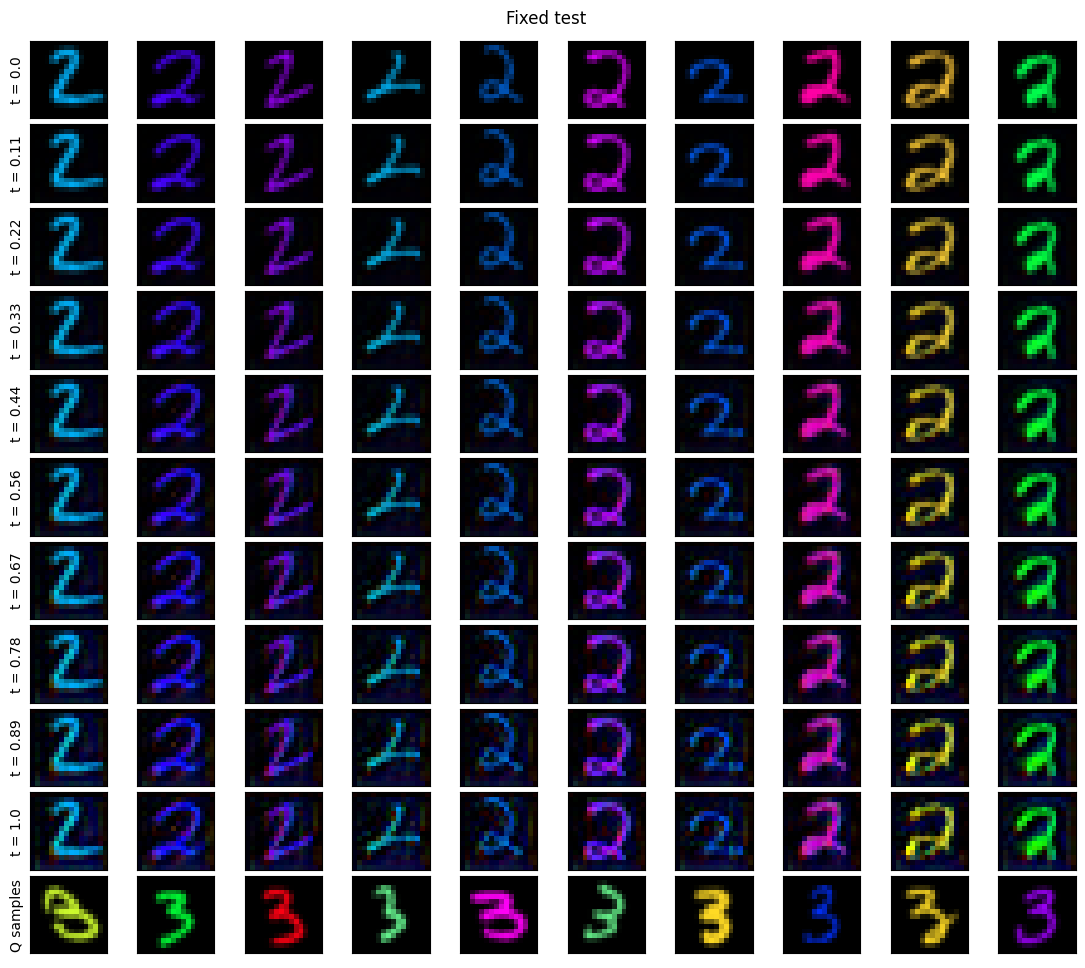

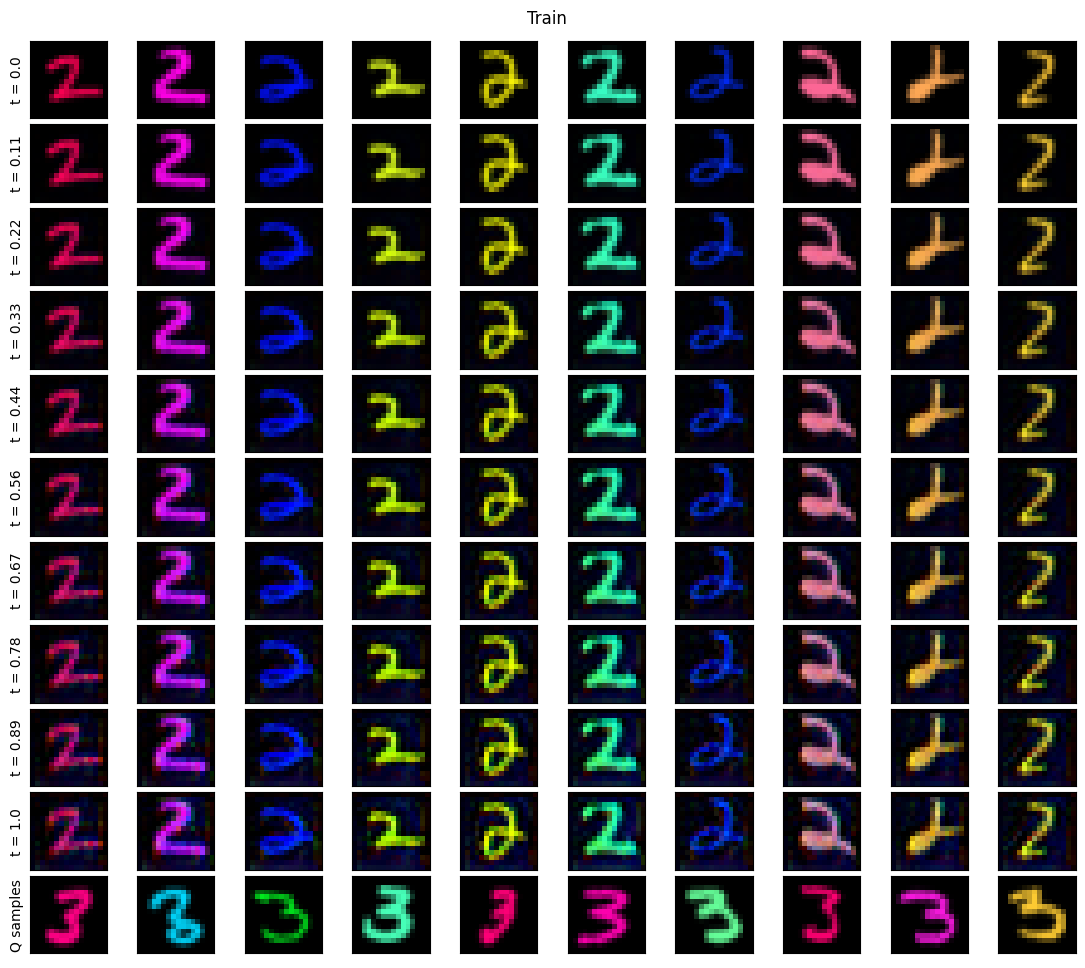

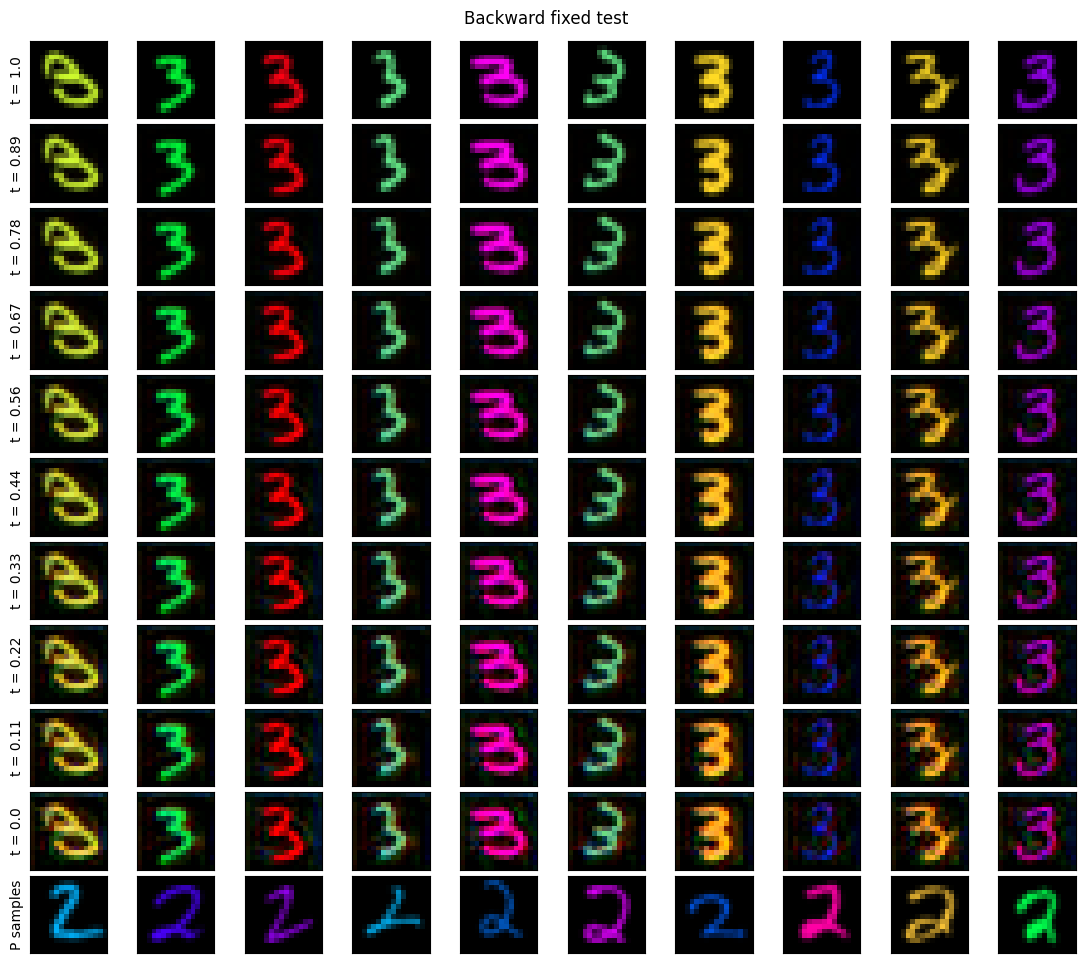

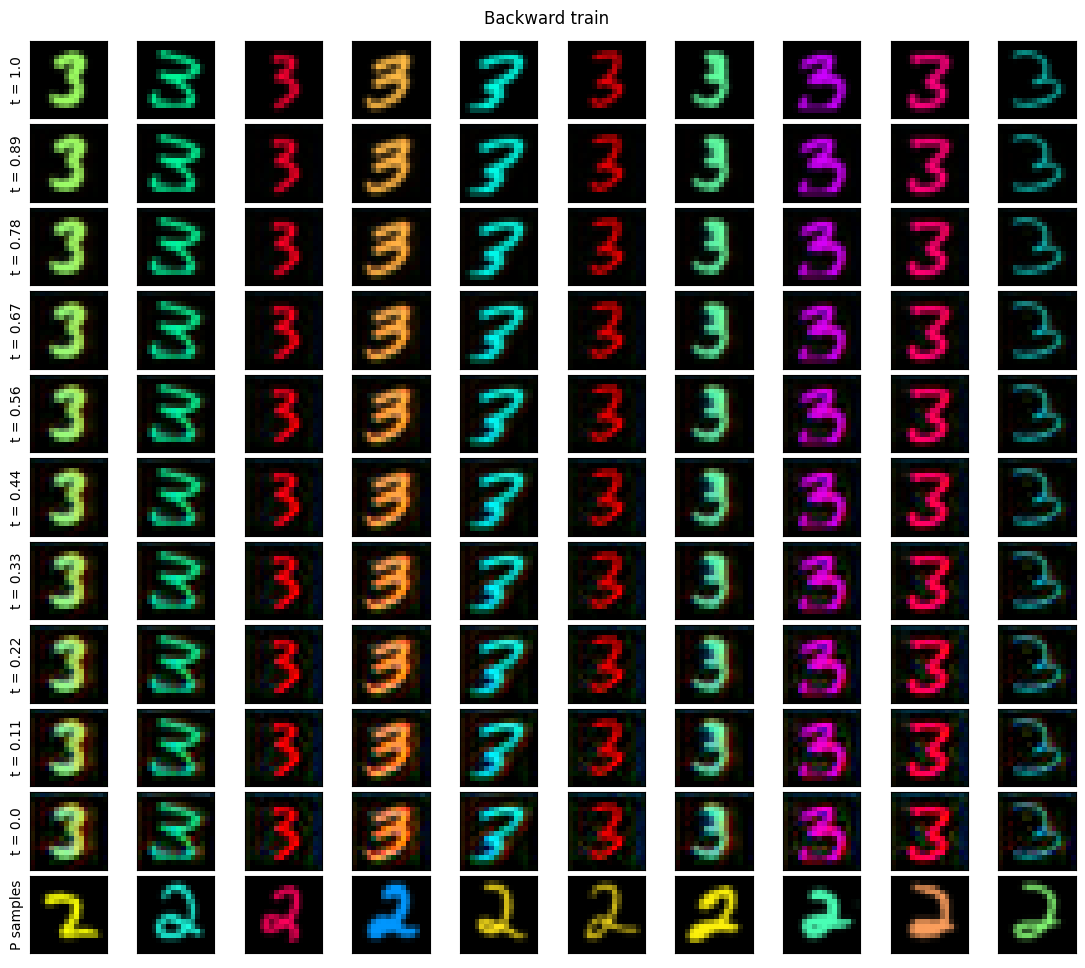

/home/user/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/user/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
../src_not/tools.py:153: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, (X, _) in enumerate(loader) if not verbose else tqdm(enumerate(loader)):


0it [00:00, ?it/s]

232.52036352089436


0it [00:00, ?it/s]

228.507918090477


  0%|          | 1/100001 [01:54<3171:10:27, 114.16s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 2/100001 [02:02<1446:42:16, 52.08s/it] 

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 3/100001 [02:09<877:17:41, 31.58s/it] 

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 4/100001 [02:17<610:36:28, 21.98s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 5/100001 [02:25<476:01:25, 17.14s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 6/100001 [02:32<381:28:48, 13.73s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 7/100001 [02:39<320:22:43, 11.53s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 8/100001 [02:46<280:51:01, 10.11s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 9/100001 [02:55<267:32:22,  9.63s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 10/100001 [03:02<244:37:07,  8.81s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 11/100001 [03:09<229:52:57,  8.28s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 12/100001 [03:16<221:40:56,  7.98s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 13/100001 [03:24<221:35:43,  7.98s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 14/100001 [03:31<214:11:02,  7.71s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 15/100001 [03:39<208:32:55,  7.51s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 16/100001 [03:46<204:28:28,  7.36s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 17/100001 [03:54<213:53:26,  7.70s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 18/100001 [04:01<209:20:40,  7.54s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 19/100001 [04:09<207:50:15,  7.48s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 20/100001 [04:17<214:30:38,  7.72s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 21/100001 [04:24<208:19:34,  7.50s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 22/100001 [04:31<204:33:12,  7.37s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 23/100001 [04:38<202:28:40,  7.29s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 24/100001 [04:46<209:43:24,  7.55s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 25/100001 [04:53<206:16:22,  7.43s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 26/100001 [05:00<203:52:20,  7.34s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 27/100001 [05:08<210:07:12,  7.57s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 28/100001 [05:16<206:52:12,  7.45s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 29/100001 [05:23<205:45:49,  7.41s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 30/100001 [05:30<202:36:36,  7.30s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 31/100001 [05:38<208:12:22,  7.50s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 32/100001 [05:45<204:52:58,  7.38s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 33/100001 [05:52<203:48:59,  7.34s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 34/100001 [06:00<202:51:21,  7.31s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 35/100001 [06:08<208:15:38,  7.50s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 36/100001 [06:15<204:26:23,  7.36s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 37/100001 [06:22<201:59:15,  7.27s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 38/100001 [06:29<206:31:47,  7.44s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 39/100001 [06:36<203:08:42,  7.32s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 40/100001 [06:44<201:49:10,  7.27s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 41/100001 [06:51<200:17:26,  7.21s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 42/100001 [06:59<206:28:25,  7.44s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 43/100001 [07:06<204:28:07,  7.36s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 44/100001 [07:13<201:18:49,  7.25s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 45/100001 [07:20<198:43:44,  7.16s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 46/100001 [07:27<201:56:33,  7.27s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 47/100001 [07:34<200:08:15,  7.21s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 48/100001 [07:42<199:43:37,  7.19s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 49/100001 [07:49<205:36:58,  7.41s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 50/100001 [07:57<204:22:42,  7.36s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

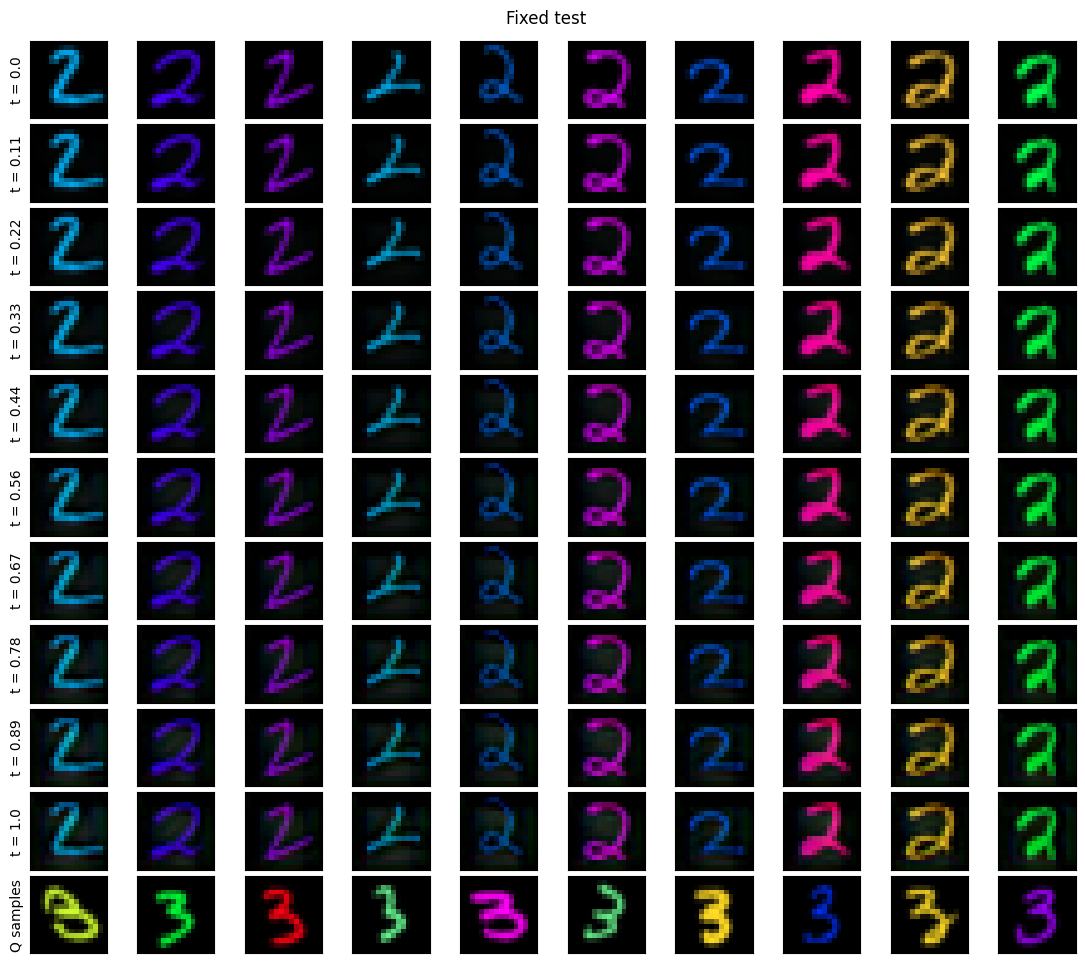

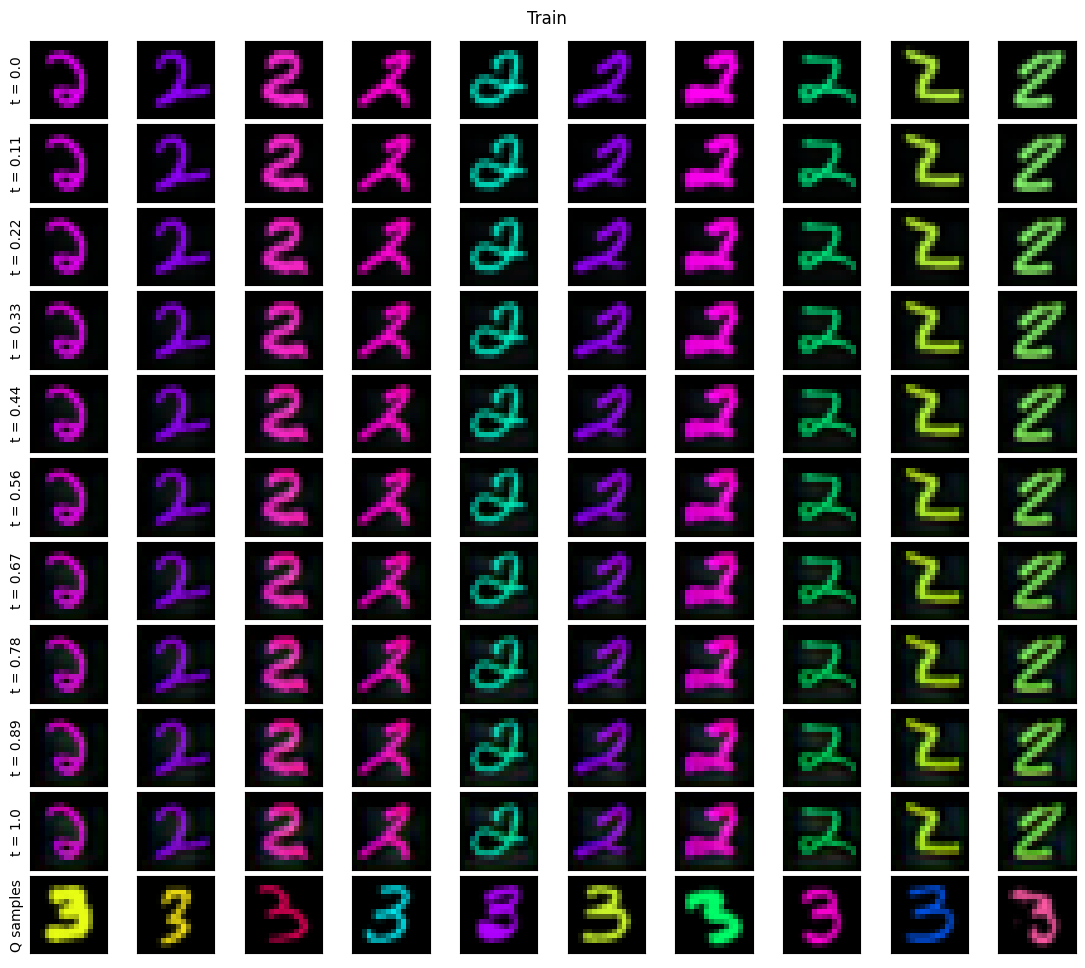

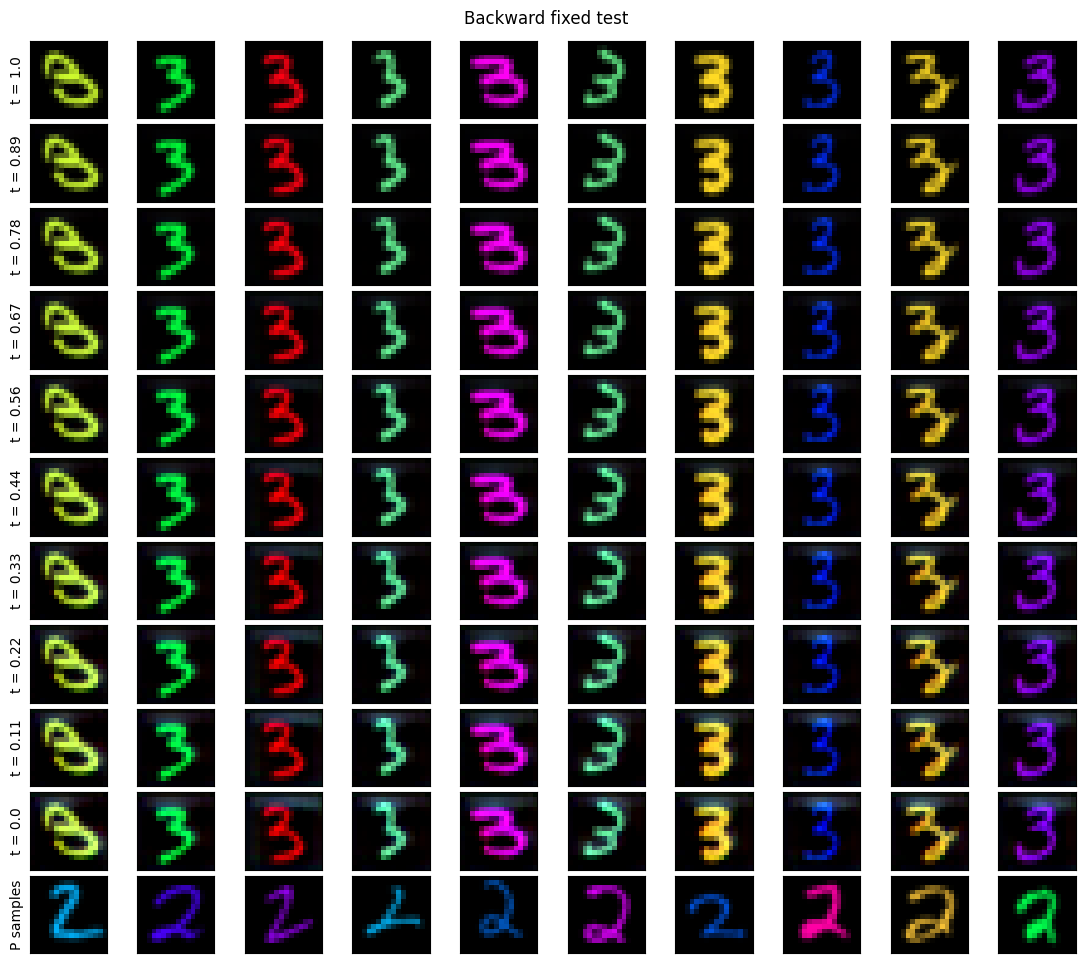

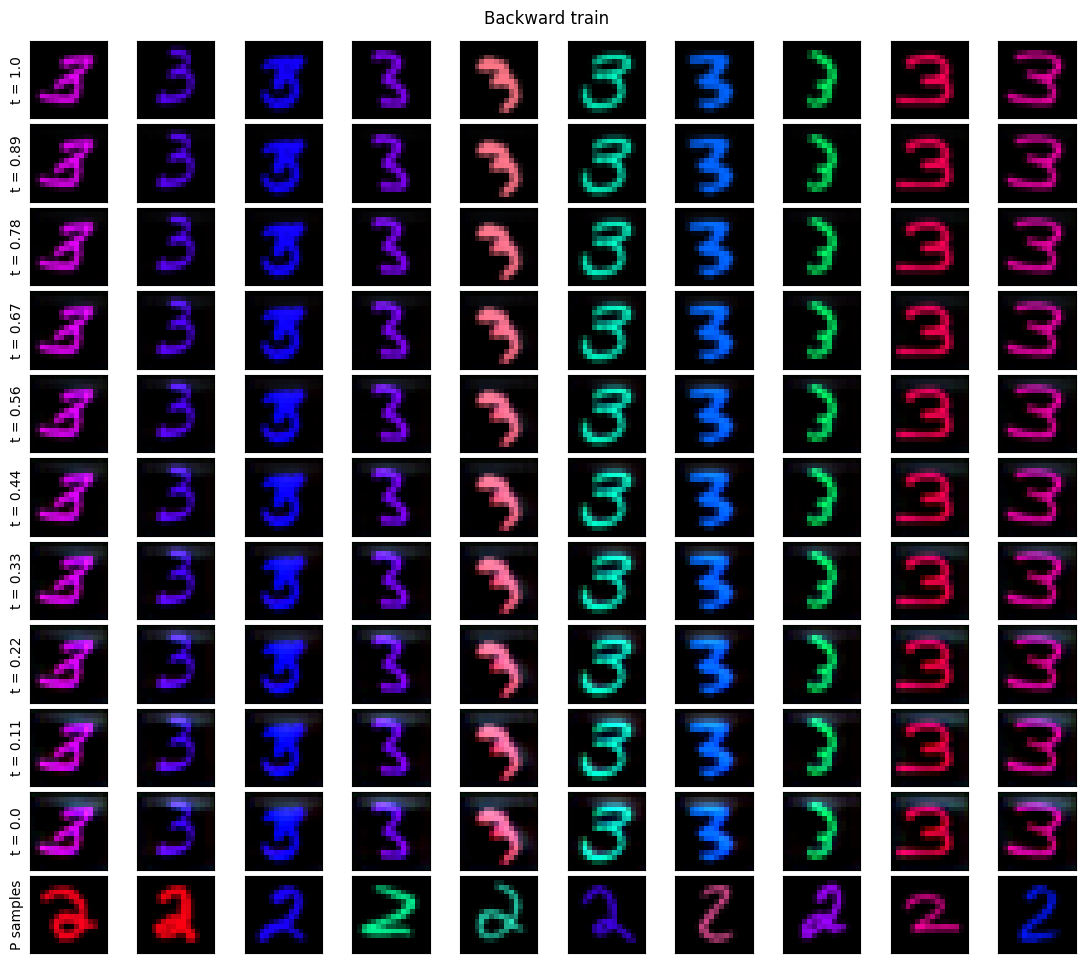

  0%|          | 51/100001 [09:00<672:06:26, 24.21s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 52/100001 [09:08<537:43:59, 19.37s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 53/100001 [09:16<437:03:33, 15.74s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 54/100001 [09:22<362:54:16, 13.07s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 55/100001 [09:29<311:56:19, 11.24s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 56/100001 [09:37<283:02:40, 10.20s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 57/100001 [09:44<258:34:21,  9.31s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 58/100001 [09:51<239:37:30,  8.63s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 59/100001 [09:59<233:05:50,  8.40s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 60/100001 [10:06<223:02:31,  8.03s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 61/100001 [10:13<214:01:44,  7.71s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 62/100001 [10:21<210:17:02,  7.57s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 63/100001 [10:29<213:43:45,  7.70s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 64/100001 [10:36<208:01:47,  7.49s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 65/100001 [10:43<205:44:21,  7.41s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 66/100001 [10:51<211:11:37,  7.61s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 67/100001 [10:58<207:34:43,  7.48s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 68/100001 [11:05<203:33:12,  7.33s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 69/100001 [11:12<201:36:13,  7.26s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 70/100001 [11:20<207:03:18,  7.46s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 71/100001 [11:28<206:18:49,  7.43s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 72/100001 [11:35<203:39:21,  7.34s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 73/100001 [11:42<200:39:34,  7.23s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 74/100001 [11:49<205:21:04,  7.40s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 75/100001 [11:56<202:17:35,  7.29s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 76/100001 [12:04<201:11:51,  7.25s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 77/100001 [12:11<204:32:49,  7.37s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 78/100001 [12:18<201:32:21,  7.26s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 79/100001 [12:25<199:52:05,  7.20s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 80/100001 [12:32<198:24:19,  7.15s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 81/100001 [12:40<205:20:04,  7.40s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 82/100001 [12:48<204:18:08,  7.36s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 83/100001 [12:55<202:04:59,  7.28s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 84/100001 [13:02<202:15:55,  7.29s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 85/100001 [13:10<207:12:27,  7.47s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 86/100001 [13:17<205:08:15,  7.39s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 87/100001 [13:24<204:22:49,  7.36s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 88/100001 [13:33<210:26:39,  7.58s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 89/100001 [13:40<208:37:58,  7.52s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 90/100001 [13:47<205:10:37,  7.39s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 91/100001 [13:54<201:57:25,  7.28s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 92/100001 [14:02<208:46:14,  7.52s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 93/100001 [14:09<205:26:32,  7.40s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 94/100001 [14:17<205:49:53,  7.42s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 95/100001 [14:24<203:15:21,  7.32s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 96/100001 [14:32<209:22:01,  7.54s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 97/100001 [14:39<204:40:51,  7.38s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 98/100001 [14:46<203:00:08,  7.32s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 99/100001 [14:54<207:13:33,  7.47s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 100/100001 [15:01<203:51:30,  7.35s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

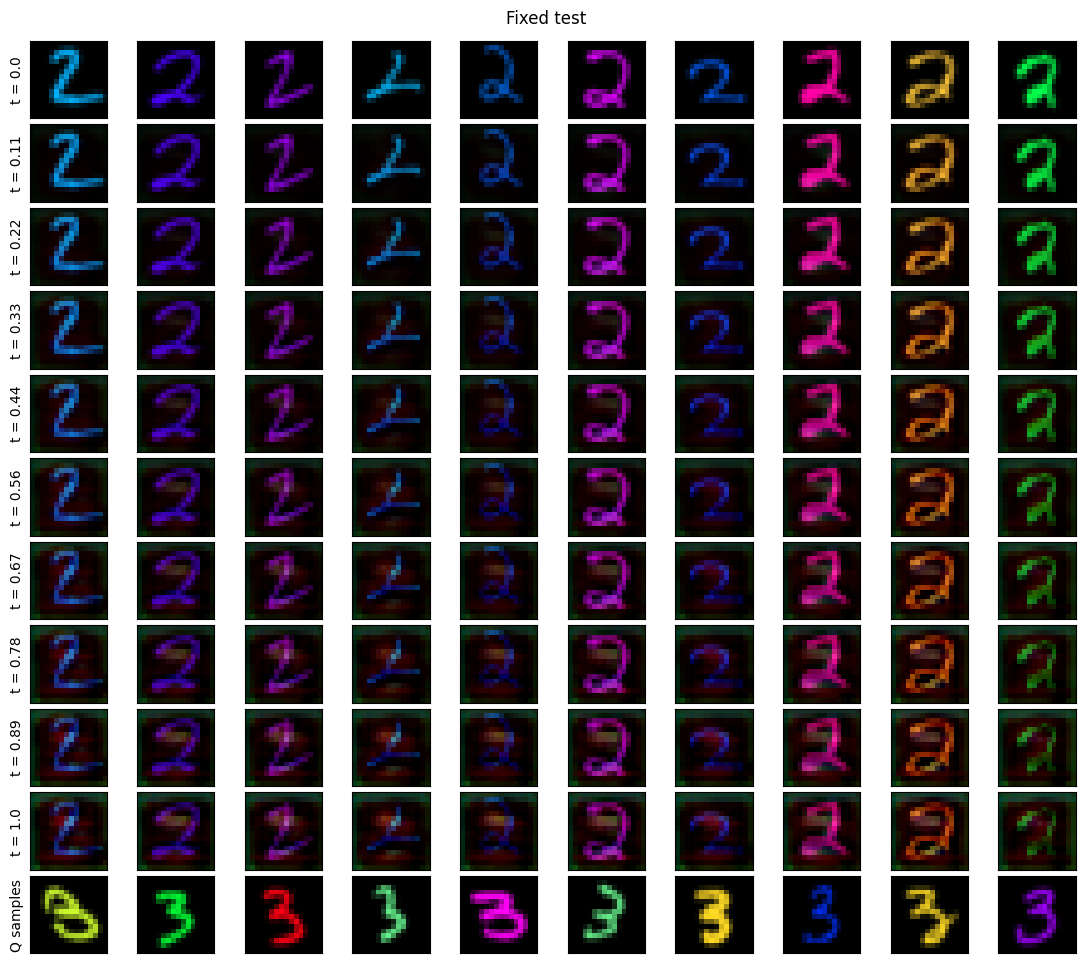

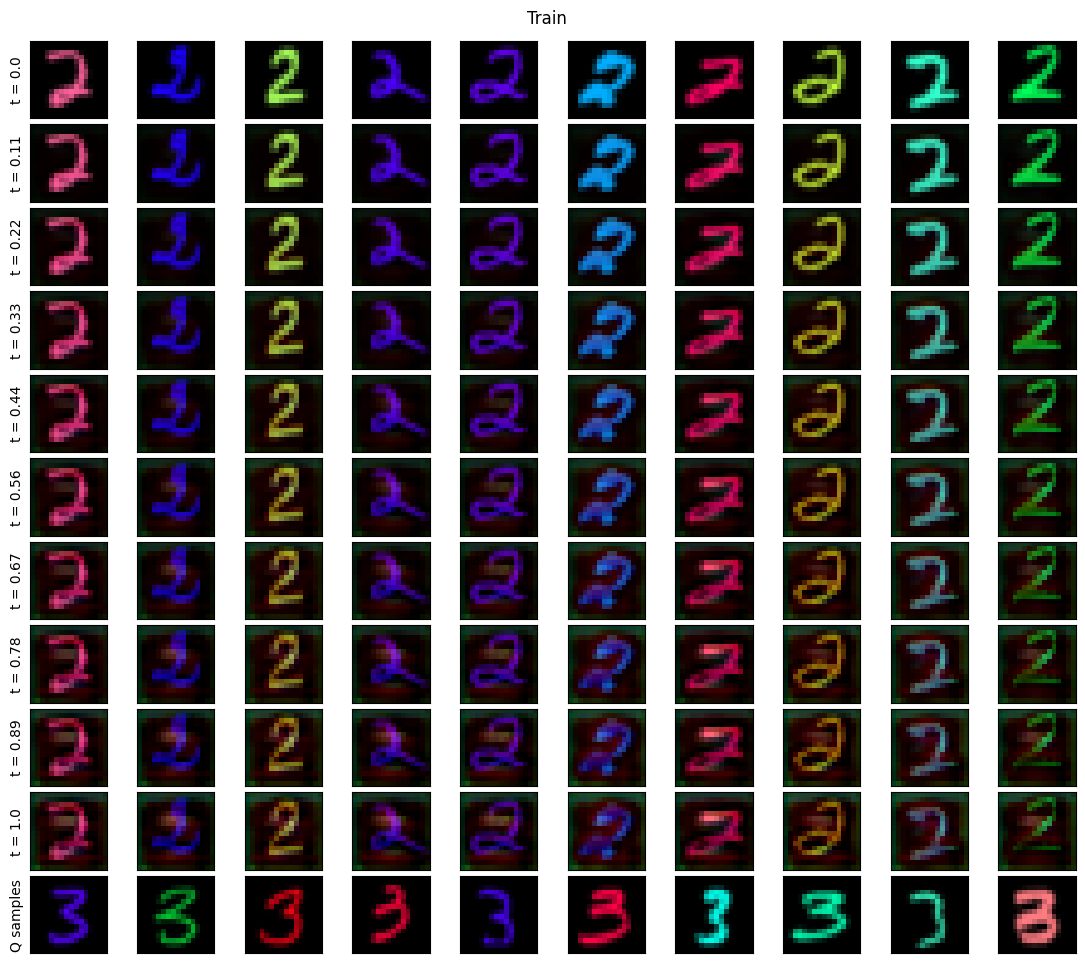

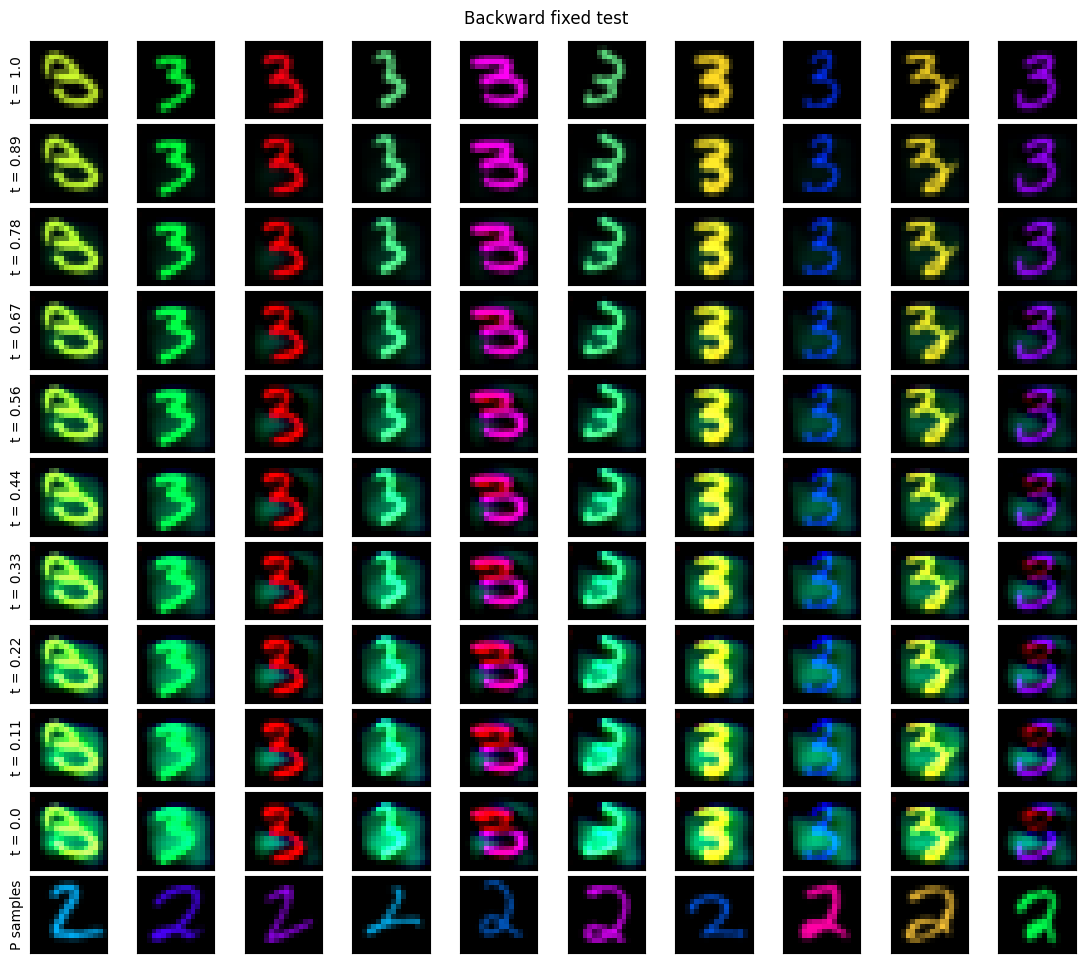

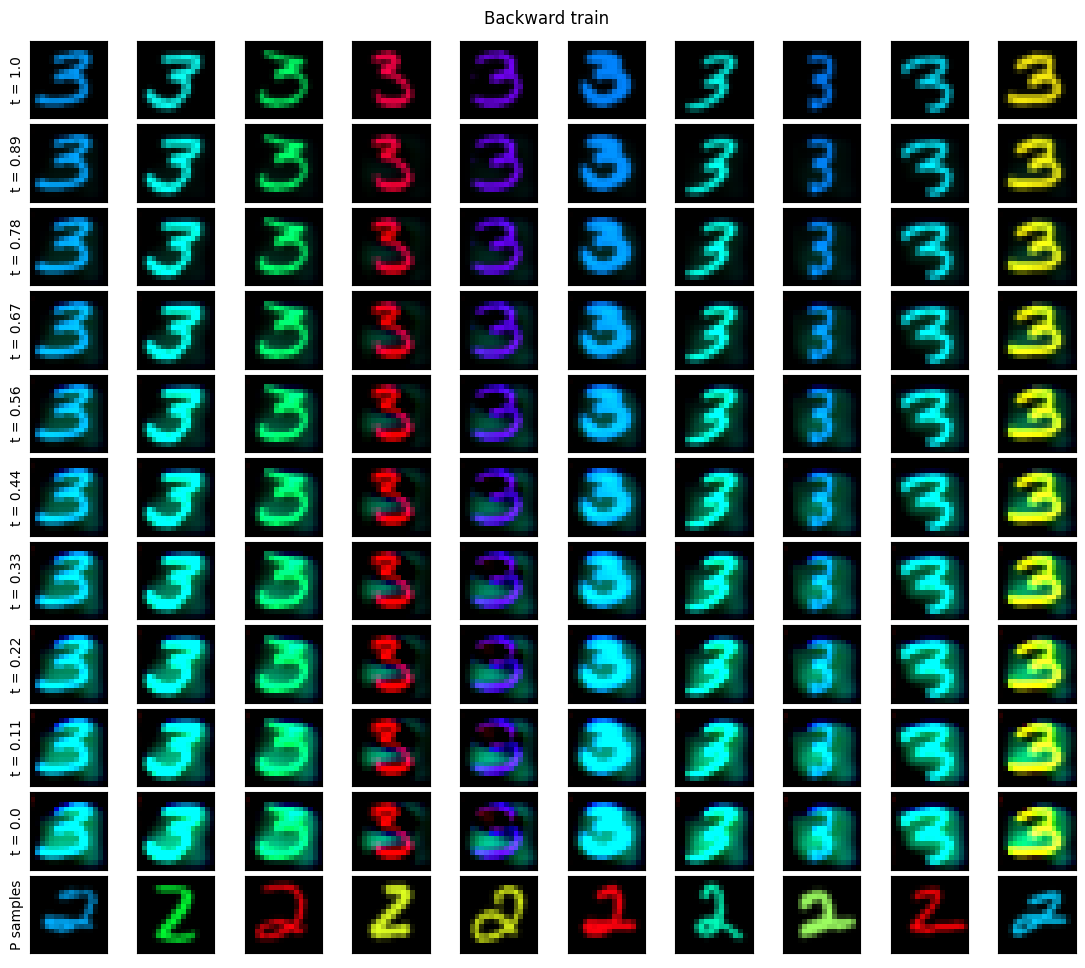

  0%|          | 101/100001 [16:04<664:18:52, 23.94s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 102/100001 [16:12<533:25:40, 19.22s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 103/100001 [16:19<433:59:34, 15.64s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 104/100001 [16:26<365:18:59, 13.16s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 105/100001 [16:34<316:50:56, 11.42s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 106/100001 [16:42<289:33:14, 10.43s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 107/100001 [16:49<262:54:52,  9.47s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 108/100001 [16:56<243:39:25,  8.78s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 109/100001 [17:04<237:45:17,  8.57s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 110/100001 [17:12<227:05:22,  8.18s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 111/100001 [17:19<218:51:55,  7.89s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 112/100001 [17:26<213:15:40,  7.69s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 113/100001 [17:34<215:56:45,  7.78s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 114/100001 [17:41<210:51:33,  7.60s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 115/100001 [17:48<205:59:21,  7.42s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 116/100001 [17:56<211:41:50,  7.63s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 117/100001 [18:04<209:41:26,  7.56s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 118/100001 [18:11<206:18:06,  7.44s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 119/100001 [18:18<204:40:35,  7.38s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 120/100001 [18:26<208:33:19,  7.52s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 121/100001 [18:33<206:11:44,  7.43s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 122/100001 [18:41<205:30:55,  7.41s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 123/100001 [18:48<205:10:32,  7.40s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 124/100001 [18:56<211:25:34,  7.62s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 125/100001 [19:03<207:39:27,  7.48s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 126/100001 [19:10<203:38:07,  7.34s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 127/100001 [19:18<207:07:40,  7.47s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 128/100001 [19:25<204:48:51,  7.38s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 129/100001 [19:33<205:14:55,  7.40s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 130/100001 [19:40<203:14:14,  7.33s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 131/100001 [19:48<207:31:56,  7.48s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 132/100001 [19:55<205:40:43,  7.41s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 133/100001 [20:02<203:08:45,  7.32s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 134/100001 [20:09<202:40:08,  7.31s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 135/100001 [20:17<210:17:13,  7.58s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 136/100001 [20:25<205:56:36,  7.42s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 137/100001 [20:32<205:45:08,  7.42s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 138/100001 [20:40<211:17:27,  7.62s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 139/100001 [20:47<206:56:25,  7.46s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 140/100001 [20:54<203:43:44,  7.34s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 141/100001 [21:01<202:55:14,  7.32s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 142/100001 [21:10<210:04:46,  7.57s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 143/100001 [21:17<207:24:38,  7.48s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 144/100001 [21:24<206:20:17,  7.44s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 145/100001 [21:32<205:48:34,  7.42s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 146/100001 [21:40<214:07:56,  7.72s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 147/100001 [21:47<210:30:47,  7.59s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 148/100001 [21:55<207:45:39,  7.49s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 149/100001 [22:03<214:11:44,  7.72s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 150/100001 [22:10<210:09:21,  7.58s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

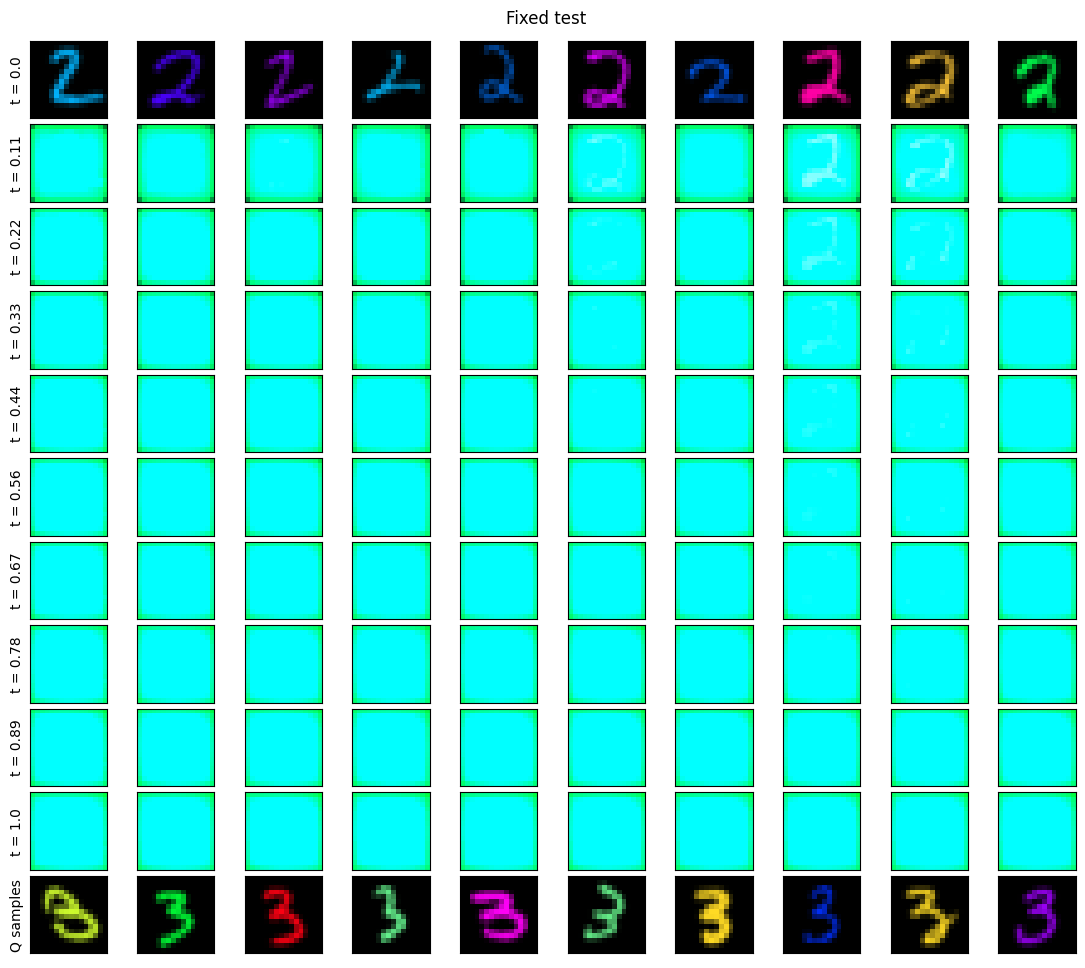

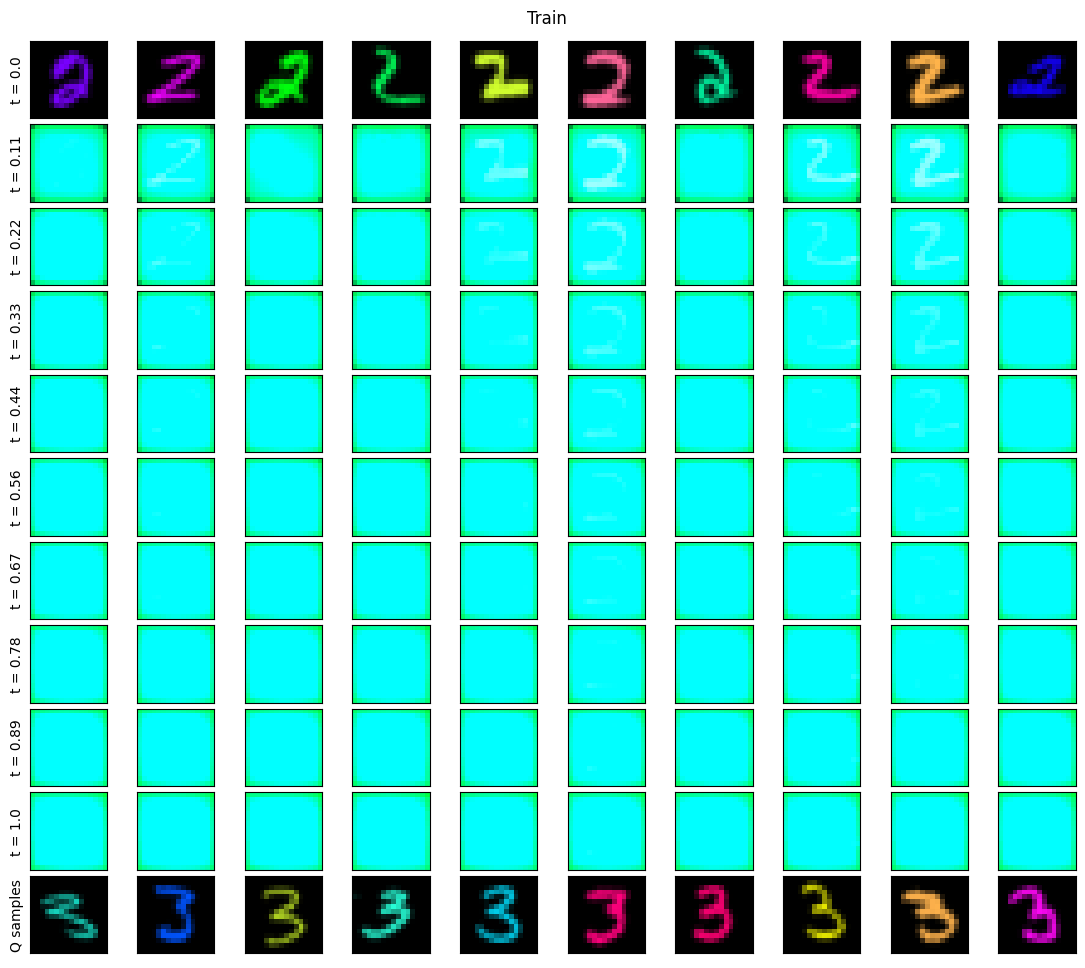

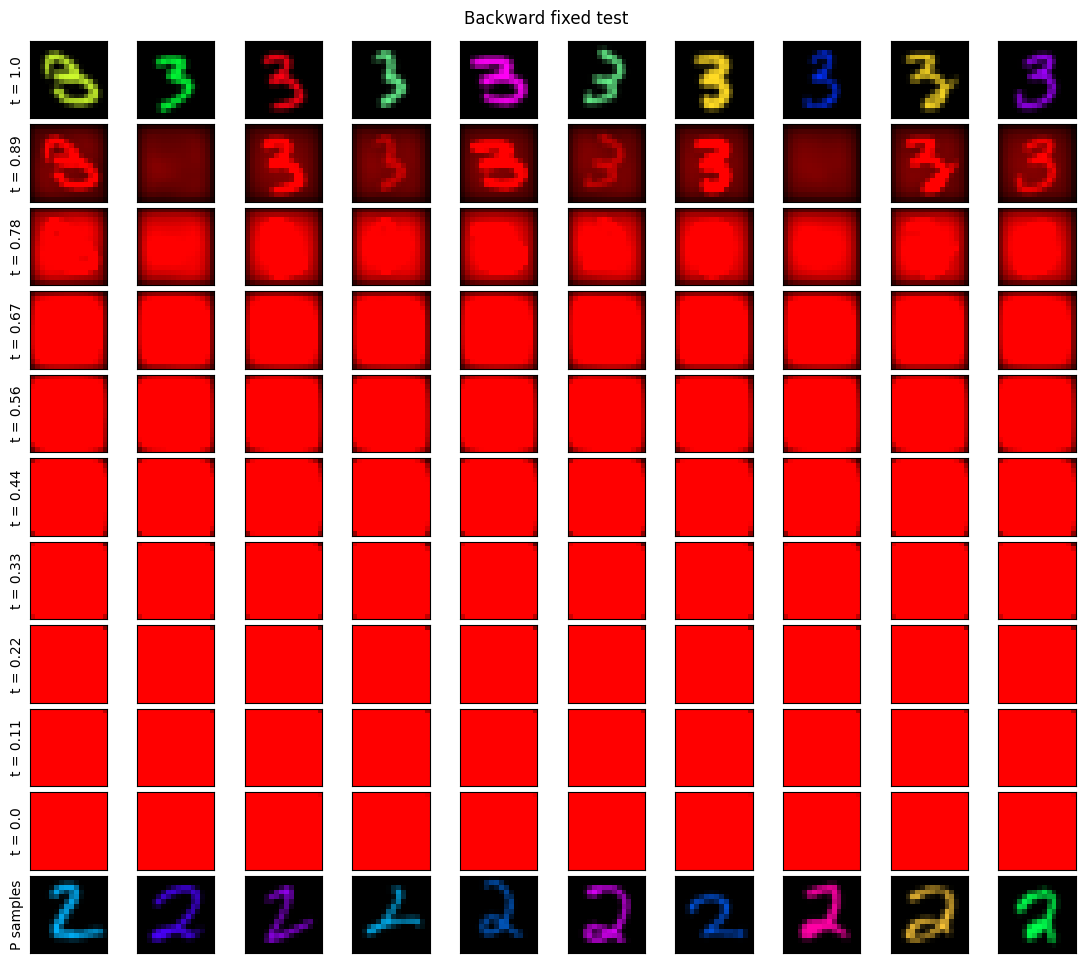

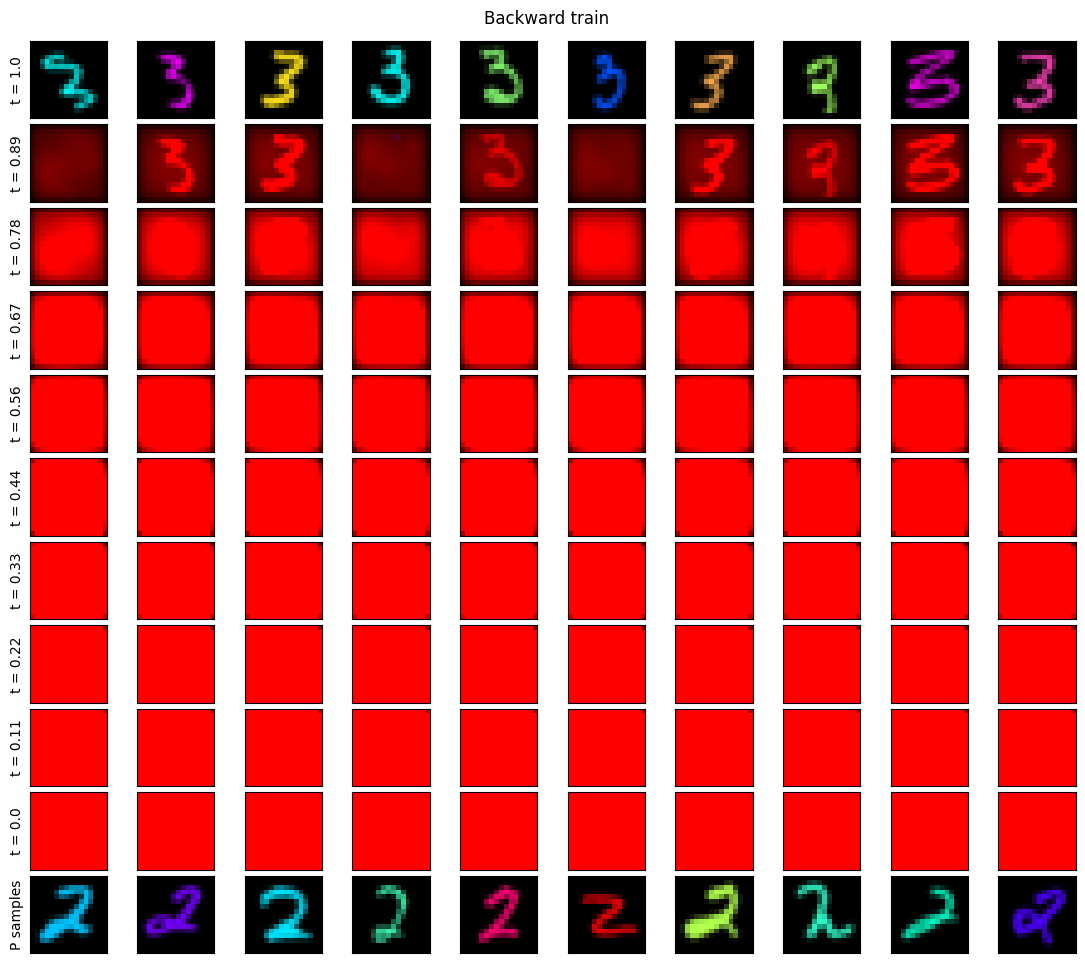

  0%|          | 151/100001 [23:13<670:52:02, 24.19s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 152/100001 [23:21<536:02:00, 19.33s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 153/100001 [23:28<434:31:35, 15.67s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 154/100001 [23:35<364:35:29, 13.15s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 155/100001 [23:42<314:16:07, 11.33s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 156/100001 [23:51<287:18:09, 10.36s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 157/100001 [23:58<262:50:33,  9.48s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 158/100001 [24:06<247:01:52,  8.91s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 159/100001 [24:14<241:14:26,  8.70s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 160/100001 [24:21<229:34:01,  8.28s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 161/100001 [24:28<221:10:29,  7.98s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 162/100001 [24:36<215:41:31,  7.78s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 163/100001 [24:44<219:06:44,  7.90s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 164/100001 [24:51<216:22:53,  7.80s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 165/100001 [24:59<212:40:36,  7.67s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 166/100001 [25:06<209:33:23,  7.56s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 167/100001 [25:14<215:20:48,  7.77s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 168/100001 [25:21<209:29:02,  7.55s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 169/100001 [25:29<207:47:01,  7.49s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 170/100001 [25:44<269:21:57,  9.71s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 171/100001 [25:51<248:01:04,  8.94s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 172/100001 [25:58<232:43:28,  8.39s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 173/100001 [26:05<225:14:22,  8.12s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 174/100001 [26:14<227:41:20,  8.21s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 175/100001 [26:21<219:34:41,  7.92s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 176/100001 [26:28<212:32:45,  7.67s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 177/100001 [26:35<209:08:05,  7.54s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 178/100001 [26:43<213:59:29,  7.72s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 179/100001 [26:50<207:41:18,  7.49s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 180/100001 [26:58<207:49:22,  7.50s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 181/100001 [27:06<215:17:35,  7.76s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 182/100001 [27:14<212:40:01,  7.67s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 183/100001 [27:21<210:32:27,  7.59s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 184/100001 [27:29<209:25:07,  7.55s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 185/100001 [27:37<215:45:58,  7.78s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 186/100001 [27:44<212:51:56,  7.68s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 187/100001 [27:52<211:13:35,  7.62s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 188/100001 [27:59<210:18:05,  7.59s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 189/100001 [28:08<218:28:37,  7.88s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 190/100001 [28:15<214:13:34,  7.73s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 191/100001 [28:23<212:29:24,  7.66s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 192/100001 [28:31<218:47:47,  7.89s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 193/100001 [28:38<212:24:05,  7.66s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 194/100001 [28:46<207:43:06,  7.49s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 195/100001 [28:53<204:12:07,  7.37s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 196/100001 [29:01<209:57:41,  7.57s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 197/100001 [29:08<206:20:06,  7.44s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 198/100001 [29:15<204:37:29,  7.38s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 199/100001 [29:22<205:12:19,  7.40s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 200/100001 [29:31<211:22:12,  7.62s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

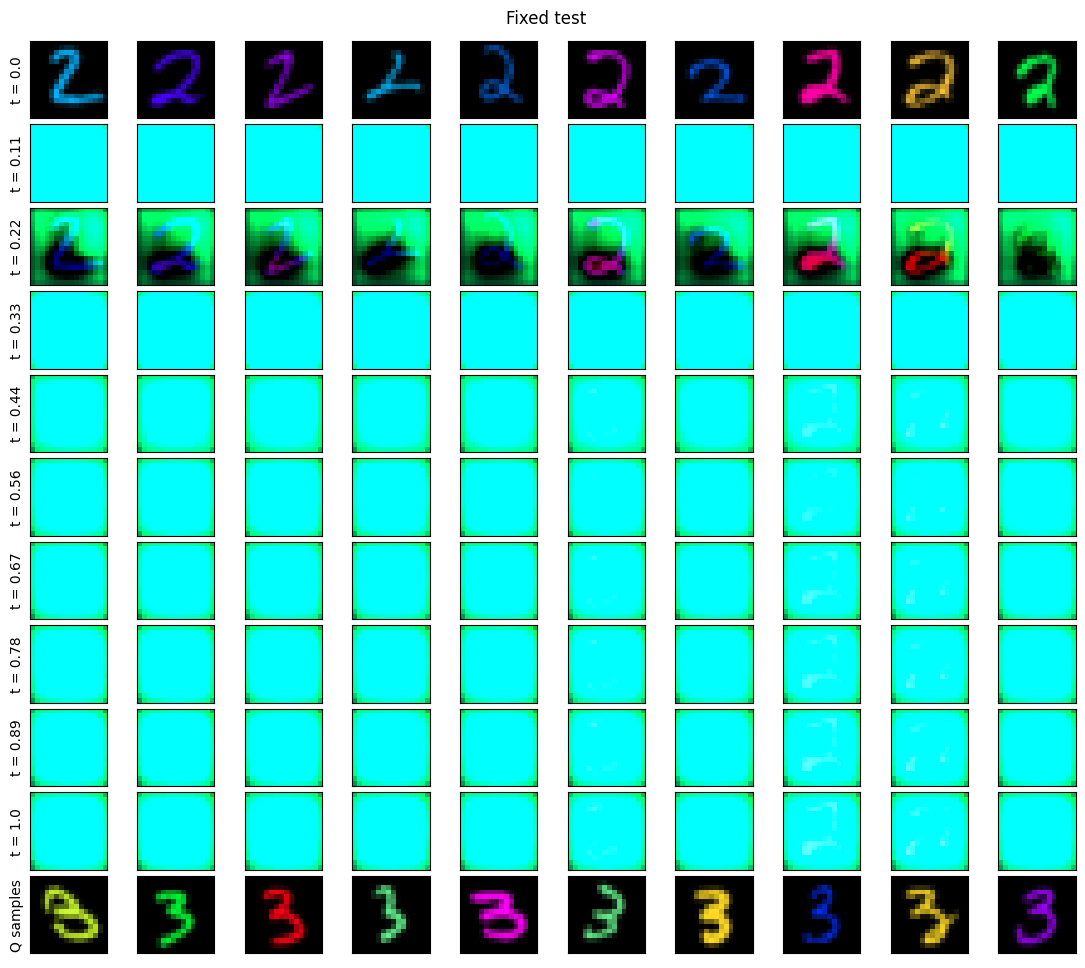

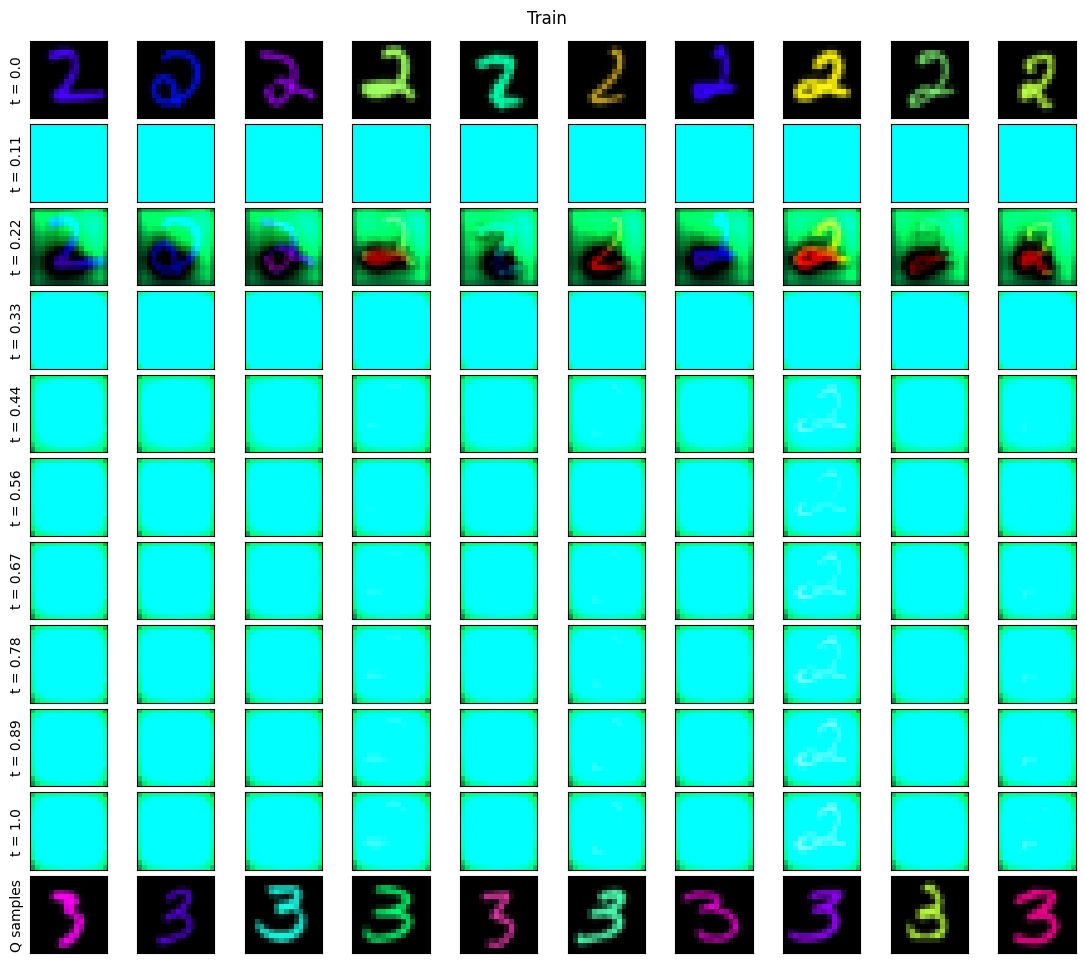

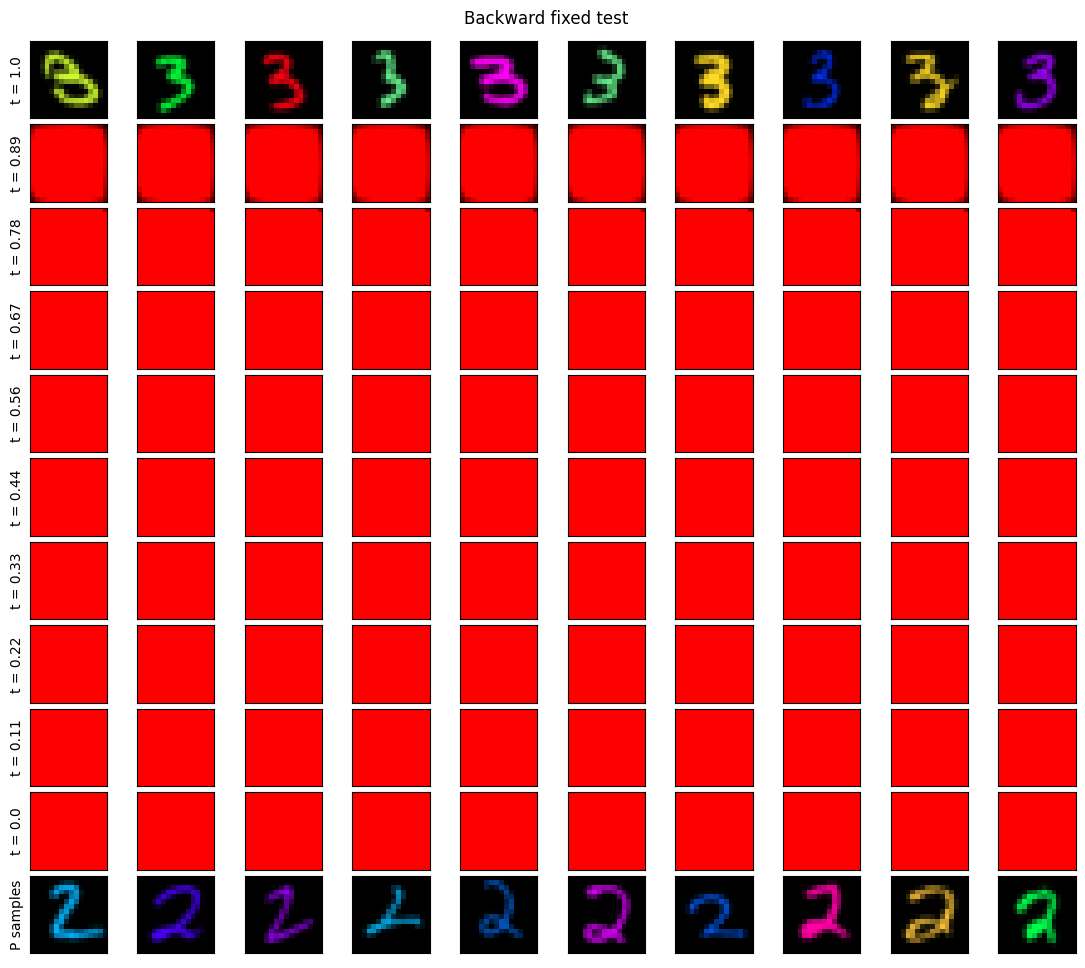

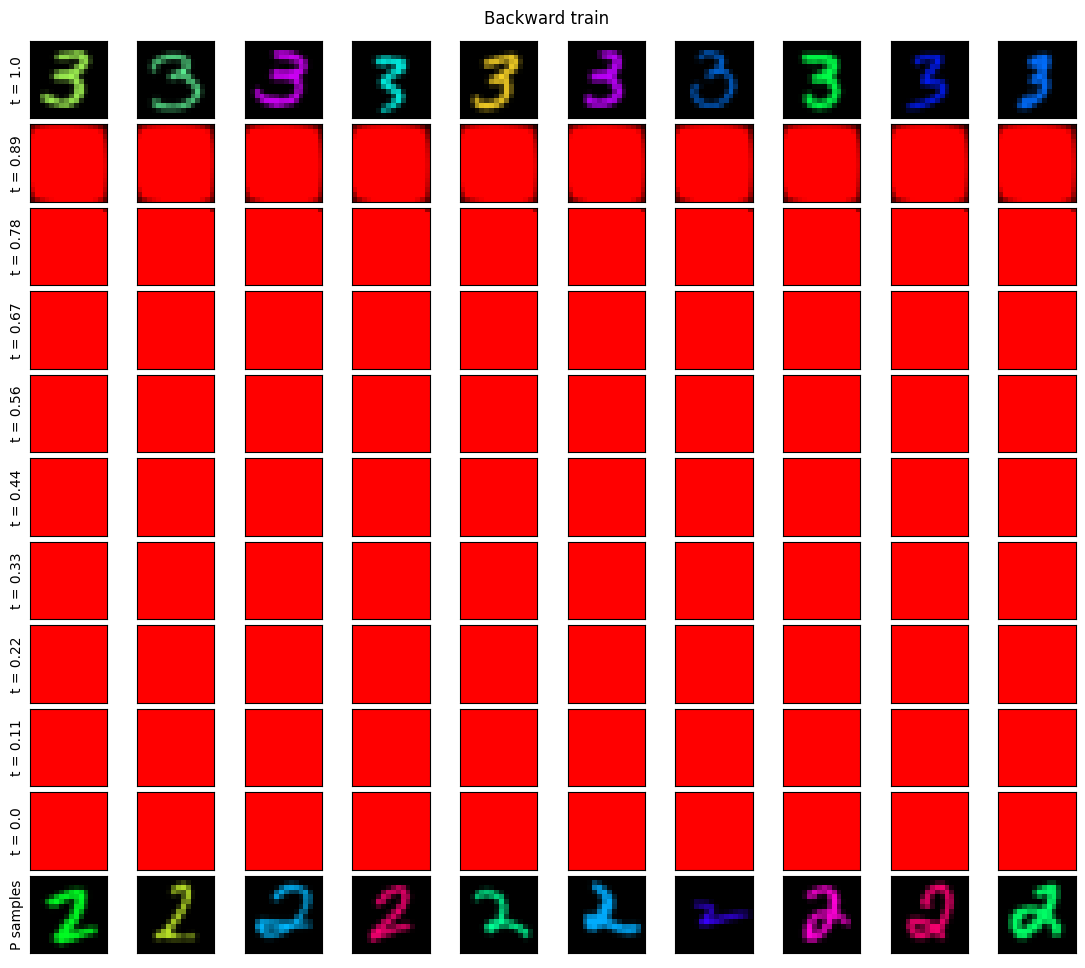

  0%|          | 201/100001 [30:34<673:15:23, 24.29s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 202/100001 [30:42<540:50:41, 19.51s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 203/100001 [30:50<439:58:00, 15.87s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 204/100001 [30:57<366:37:55, 13.23s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 205/100001 [31:04<317:10:37, 11.44s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 206/100001 [31:12<288:37:00, 10.41s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 207/100001 [31:19<262:34:26,  9.47s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 208/100001 [31:27<246:16:51,  8.88s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 209/100001 [31:35<241:16:52,  8.70s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 210/100001 [31:42<229:17:33,  8.27s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 211/100001 [31:50<221:20:08,  7.98s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 212/100001 [31:57<215:49:16,  7.79s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 213/100001 [32:05<218:36:02,  7.89s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 214/100001 [32:12<214:33:05,  7.74s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 215/100001 [32:20<210:39:10,  7.60s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 216/100001 [32:27<208:14:12,  7.51s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 217/100001 [32:35<213:33:03,  7.70s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 218/100001 [32:43<211:36:29,  7.63s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 219/100001 [32:50<210:06:34,  7.58s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 220/100001 [32:58<214:26:49,  7.74s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 221/100001 [33:06<213:22:17,  7.70s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 222/100001 [33:13<211:03:29,  7.61s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 223/100001 [33:20<208:07:21,  7.51s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 224/100001 [33:28<212:58:26,  7.68s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 225/100001 [33:36<209:51:06,  7.57s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 226/100001 [33:43<208:07:14,  7.51s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 227/100001 [33:50<206:18:56,  7.44s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 228/100001 [33:58<209:43:30,  7.57s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 229/100001 [34:06<206:39:57,  7.46s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 230/100001 [34:13<205:29:47,  7.41s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 231/100001 [34:21<212:11:23,  7.66s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 232/100001 [34:28<207:43:06,  7.50s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 233/100001 [34:35<205:56:10,  7.43s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 234/100001 [34:43<205:06:36,  7.40s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 235/100001 [34:51<212:28:30,  7.67s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 236/100001 [34:59<210:49:11,  7.61s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 237/100001 [35:06<209:05:43,  7.55s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 238/100001 [35:13<207:48:24,  7.50s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 239/100001 [35:21<212:53:23,  7.68s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 240/100001 [35:29<207:46:04,  7.50s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 241/100001 [35:36<204:37:00,  7.38s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 242/100001 [35:44<210:15:41,  7.59s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 243/100001 [35:51<207:52:48,  7.50s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 244/100001 [35:58<204:23:35,  7.38s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 245/100001 [36:05<203:25:00,  7.34s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 246/100001 [36:13<208:42:30,  7.53s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 247/100001 [36:20<205:09:27,  7.40s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 248/100001 [36:27<201:32:29,  7.27s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 249/100001 [36:35<201:05:51,  7.26s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 250/100001 [36:42<206:10:51,  7.44s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

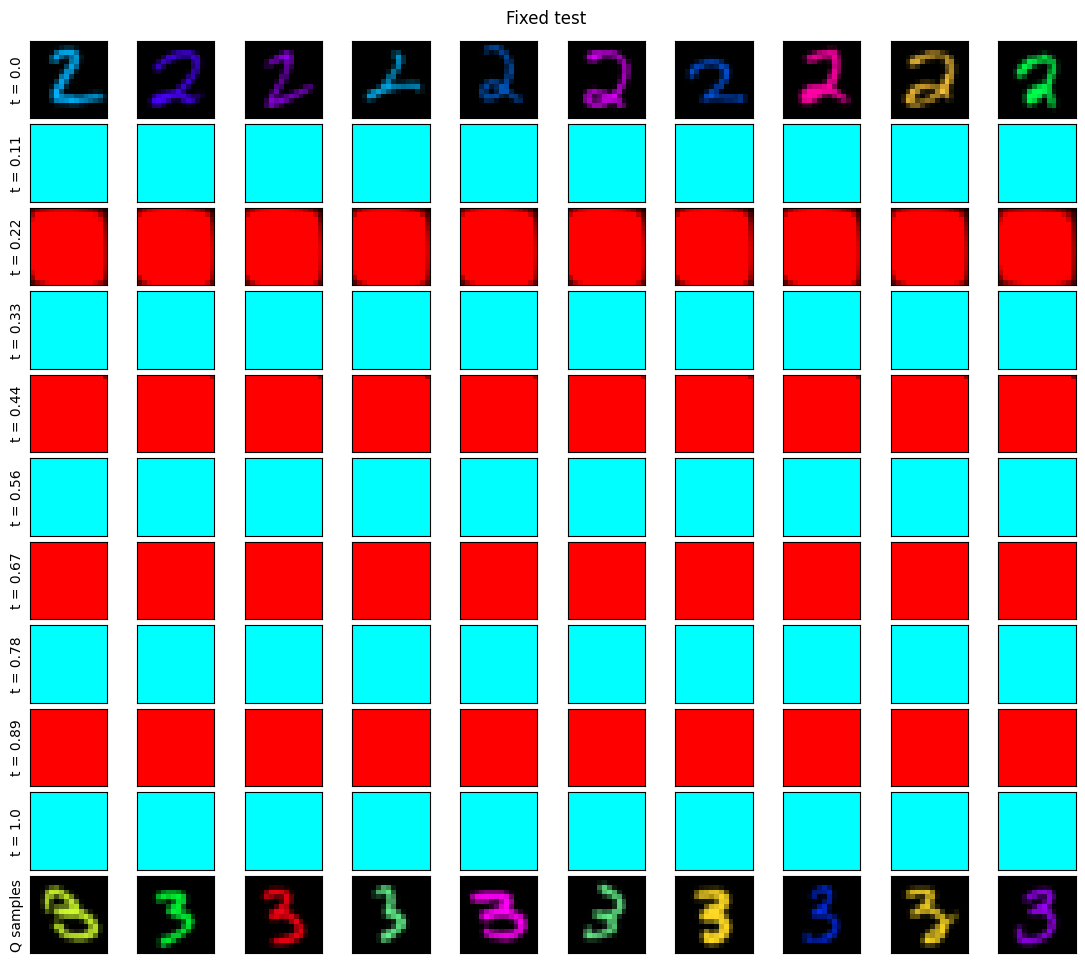

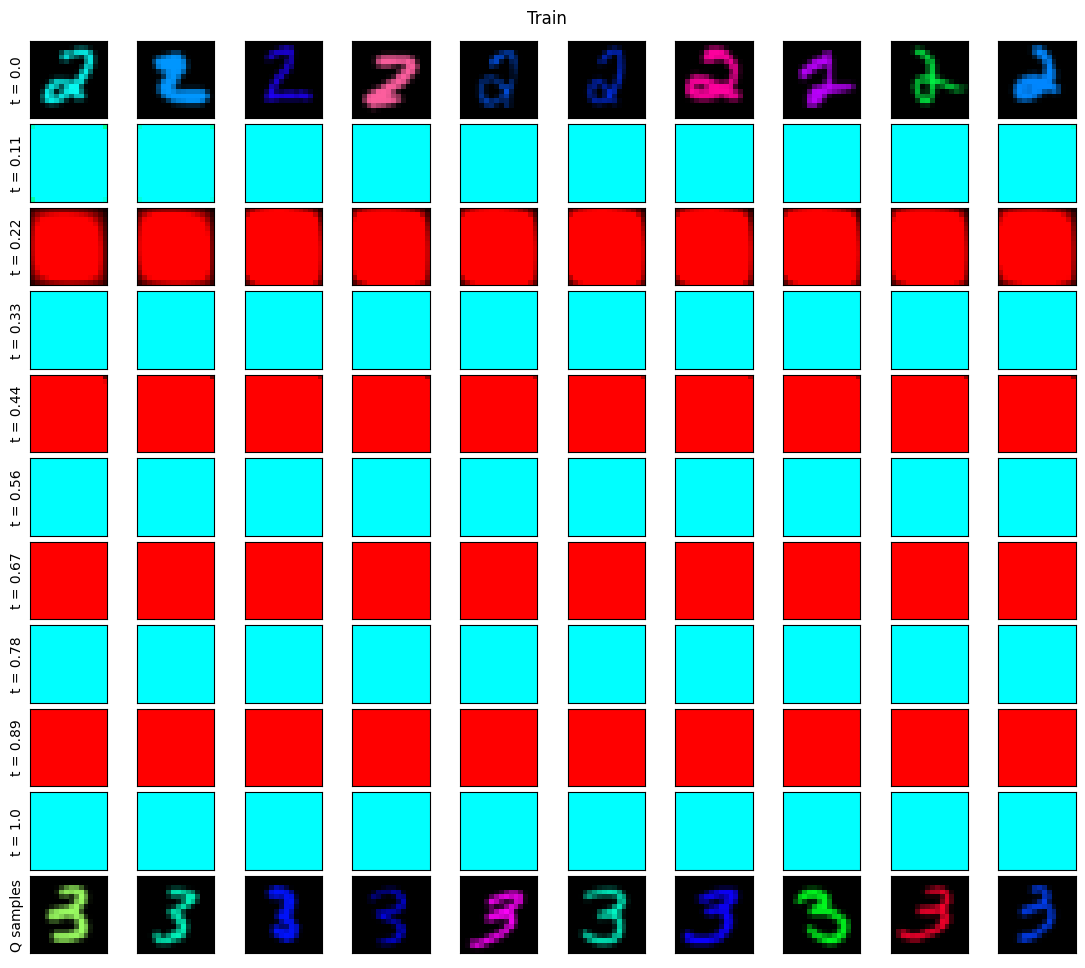

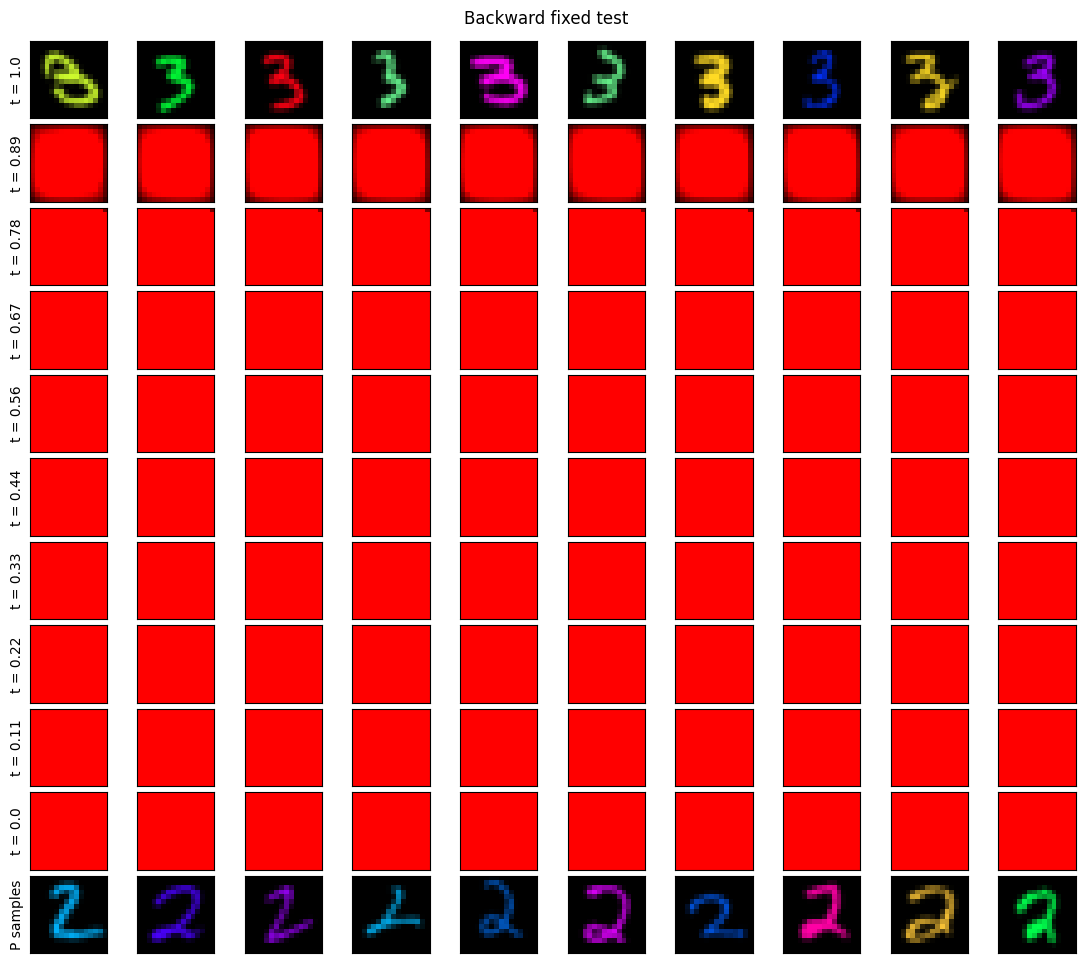

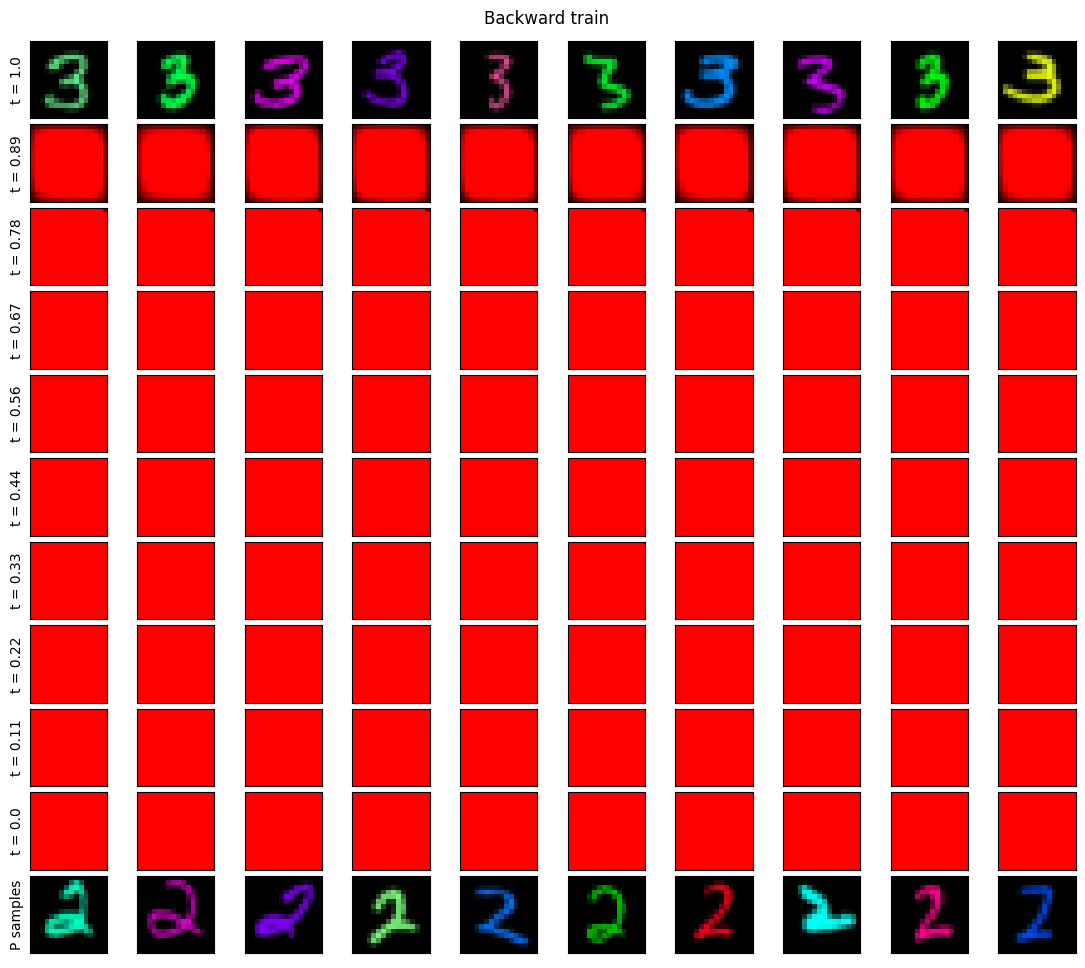

  0%|          | 251/100001 [37:45<663:17:33, 23.94s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 252/100001 [37:53<531:39:10, 19.19s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 253/100001 [38:01<434:33:37, 15.68s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 254/100001 [38:08<366:54:38, 13.24s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 255/100001 [38:15<317:17:17, 11.45s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 256/100001 [38:23<288:29:29, 10.41s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 257/100001 [38:31<261:57:06,  9.45s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 258/100001 [38:38<243:47:36,  8.80s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 259/100001 [38:45<231:42:30,  8.36s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 260/100001 [38:53<228:38:06,  8.25s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 261/100001 [39:00<220:18:09,  7.95s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 262/100001 [39:08<215:33:57,  7.78s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 263/100001 [39:16<221:06:09,  7.98s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 264/100001 [39:24<216:50:56,  7.83s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 265/100001 [39:31<213:03:50,  7.69s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 266/100001 [39:38<210:41:31,  7.61s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 267/100001 [39:47<215:37:24,  7.78s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 268/100001 [39:54<210:33:42,  7.60s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 269/100001 [40:01<208:10:48,  7.51s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 270/100001 [40:08<206:41:26,  7.46s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 271/100001 [40:17<211:34:40,  7.64s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 272/100001 [40:24<209:22:28,  7.56s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 273/100001 [40:31<206:02:21,  7.44s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 274/100001 [40:39<208:38:32,  7.53s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 275/100001 [40:46<208:23:58,  7.52s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 276/100001 [40:54<205:53:45,  7.43s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 277/100001 [41:01<204:13:04,  7.37s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 278/100001 [41:09<209:25:25,  7.56s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 279/100001 [41:16<205:27:15,  7.42s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 280/100001 [41:23<206:11:37,  7.44s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 281/100001 [41:30<203:17:58,  7.34s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 282/100001 [41:38<207:56:00,  7.51s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 283/100001 [41:45<203:49:26,  7.36s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 284/100001 [41:53<203:25:46,  7.34s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 285/100001 [42:01<209:41:30,  7.57s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 286/100001 [42:08<207:44:25,  7.50s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 287/100001 [42:15<204:52:15,  7.40s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 288/100001 [42:22<202:56:42,  7.33s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 289/100001 [42:31<211:53:39,  7.65s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 290/100001 [42:38<209:07:13,  7.55s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 291/100001 [42:45<206:00:36,  7.44s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 292/100001 [42:53<204:29:44,  7.38s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 293/100001 [43:01<209:37:46,  7.57s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 294/100001 [43:08<206:50:46,  7.47s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 295/100001 [43:15<205:06:39,  7.41s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 296/100001 [43:23<209:40:53,  7.57s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 297/100001 [43:30<207:28:33,  7.49s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 298/100001 [43:37<204:25:38,  7.38s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

  0%|          | 299/100001 [43:45<203:32:30,  7.35s/it]

backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.6667, 0.5556, 0.4444, 0.3333, 0.2222, 0.1111,
        0.0000], device='cuda:0')
backward int_time =  tensor([1.0000, 0.8889, 0.7778, 0.

  0%|          | 300/100001 [43:53<209:27:09,  7.56s/it]

forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], device='cuda:0')
forward int_time =  tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.

In [ ]:
PLOT_INTERVAL = 50
CPKT_INTERVAL = 500
# PLOT_INTERVAL = 1
# CPKT_INTERVAL = 1
train_loop_v5(T=T, f_y=f_y, f_x=f_x,
              X_sampler=sample_mnist_2, Y_sampler=sample_mnist_3,
              BATCH_SIZE=BATCH_SIZE,
              T_ITERS=10, MAX_STEPS=100001,
              regularized=True)

In [ ]:
# PLOT_INTERVAL = 100
# CPKT_INTERVAL = 500
# # PLOT_INTERVAL = 1
# # CPKT_INTERVAL = 1
# train_loop(T, f, sample_mnist_2, sample_mnist_3, BATCH_SIZE=64)

In [ ]:
# def train_loop(T, f, X_sampler, Y_sampler, BATCH_SIZE, T_ITERS=10, MAX_STEPS=100001, regularized=True):

#     wandb.init(project='ode_strong_not', name=f'dynamic_ot_euler10step_MNIST_23_kostil') 
#     OUTPUT_PATH = f'checkpoints/dynamic_ot_euler10step_MNIST_23_kostil'
#     os.makedirs(OUTPUT_PATH, exist_ok=True)
#     T_LR = 1e-4
#     f_LR = 1e-4
    
#     T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
#     f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)
    
#     for step in tqdm(range(MAX_STEPS)):
#         # T optimization
#         unfreeze(T); freeze(f)
#         avg_gen_opt_step_time = 0
#         avg_num_func_eval_per_opt_step = 0
#         for t_iter in range(T_ITERS):

#             generator_opt_step_time = time.time()
#             T_opt.zero_grad()
#             X = X_sampler().cuda()

#             t_eval, trajectories, reg_loss = T(X, return_trajectory=True)
#             T_X = trajectories[-1]

#             # total_loss
#             if COST == 'mse':
#                 T_loss = F.mse_loss(X, T_X).mean() - f(T_X).mean() + reg_loss      
#             elif COST == 'dynamic_ot':
#                 T_loss = reg_loss - f(T_X).mean() 
#             else:
#                 raise Exception('Unknown COST')

#             with torch.no_grad():
#                 num_func_eval = T.nfe
#             T_loss.backward(); T_opt.step()
#             with torch.no_grad():
#                 num_func_eval_per_opt_step = T.nfe - num_func_eval

#             generator_opt_step_time = time.time() - generator_opt_step_time
#             avg_gen_opt_step_time += generator_opt_step_time
#             avg_num_func_eval_per_opt_step += num_func_eval_per_opt_step

#         avg_gen_opt_step_time /= T_ITERS 
#         avg_num_func_eval_per_opt_step /= T_ITERS
#         # del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()
        
#         # f optimization
#         freeze(T); unfreeze(f)
#         discriminator_opt_step_time = time.time()
#         X = X_sampler().cuda()
#         with torch.no_grad():
#             T_X, _ = T(X)
#         Y = Y_sampler().cuda()
#         f_opt.zero_grad()
#         f_loss = f(T_X).mean() - f(Y).mean()
#         f_loss.backward(); f_opt.step();
#         discriminator_opt_step_time = time.time() - discriminator_opt_step_time
#         wandb.log({'f_loss' : f_loss.item(),
#                    'T_loss' : T_loss.item(),
#                    'reg_loss' : reg_loss.item(),
#                   'avg_num_func_eval_per_opt_step' : avg_num_func_eval_per_opt_step,
#                   'avg_gen_opt_step_time' : avg_gen_opt_step_time,
#                   'discriminator_opt_step_time' : discriminator_opt_step_time
#                   }, step=step) 

#         if step % PLOT_INTERVAL == 0:
#             print('Plotting')
#             # clear_output(wait=True)
#             figs, axes = plot_trajectories(T, BATCH_SIZE,
#                                               sample_mnist_2,
#                                               sample_mnist_3,
#                                               # num_steps=10,
#                                               backward=False)
#             figs_total = figs
#             figs, axes = plot_trajectories(T, BATCH_SIZE,
#                               sample_mnist_2,
#                               sample_mnist_3,
#                               # num_steps=10,
#                               backward=True)
#             figs_total += figs

#             wandb.log({'Fixed Images' : [wandb.Image(fig) for fig in figs_total]}, step=step) 
#             [plt.show(fig) for fig in figs_total]; [plt.close(fig) for fig in figs_total]

#         if step % CPKT_INTERVAL == 0:
            
#             mu, sigma = get_pushed_loader_stats(Last_T(T), test_sampler_x.loader, batch_size=BATCH_SIZE, verbose=True)
#             fid_forward = calculate_frechet_distance(mu_data_y, sigma_data_y, mu, sigma)
#             print(fid_forward)

#             int_time = T.integration_time
#             new_int_time = int_time.flip(dims=(0,))
#             T.integration_time = new_int_time
#             mu, sigma = get_pushed_loader_stats(Last_T(T), test_sampler_y.loader, batch_size=BATCH_SIZE, verbose=True)
#             fid_backward = calculate_frechet_distance(mu_data_x, sigma_data_x, mu, sigma)
#             T.integration_time = int_time
#             print(fid_backward)
#             wandb.log({'FID_forward' : fid_forward,
#                       'FID_backward' : fid_backward,
#                   }, step=step) 

#             torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'{SEED}_{step}.pt'))
#             torch.save(f.state_dict(), os.path.join(OUTPUT_PATH, f'f_{SEED}_{step}.pt'))
#             torch.save(f_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_opt_{SEED}_{step}.pt'))
#             torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{step}.pt'))

In [ ]:
# PLOT_INTERVAL = 100
# CPKT_INTERVAL = 500
# # PLOT_INTERVAL = 1
# # CPKT_INTERVAL = 1
# train_loop(T, f, sample_mnist_2, sample_mnist_3, BATCH_SIZE=64)


In [ ]:
torch.save(T.state_dict(), f'checkpoints/dynamic_ot_euler10step_MNIST_23_adjoint/{SEED}_last.pt')
torch.save(f.state_dict(), f'checkpoints/dynamic_ot_euler10step_MNIST_23_adjoint/f_{SEED}_last.pt')
torch.save(f_opt.state_dict(), f'checkpoints/dynamic_ot_euler10step_MNIST_23/f_opt_{SEED}_last.pt')
torch.save(T_opt.state_dict(), f'checkpoints/dynamic_ot_euler10step_MNIST_23_adjoint/T_opt_{SEED}_last.pt')

In [ ]:
figs, axes = plot_trajectories(T, BATCH_SIZE,
                              sample_mnist_2,
                              sample_mnist_3,
                              num_steps=10,
                              backward=False)

In [ ]:
figs, axes = plot_trajectories(T, BATCH_SIZE,
                              sample_mnist_2,
                              sample_mnist_3,
                              num_steps=10,
                              backward=True)

In [ ]:
figs[0].savefig('MNIST_23_backward_test.png')
figs[1].savefig('MNIST_23_backward_train.png')